In [60]:
import numpy as np 
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.patches import Arc
from matplotlib.patches import Rectangle
from matplotlib.patches import Circle
import matplotlib.ticker as mtick
from matplotlib.patches import ConnectionPatch
from matplotlib.patches import FancyBboxPatch
import matplotlib
import matplotlib.ticker as mtick
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [61]:
# Kaggle Surveys from 2018 to 2022
df_18 = pd.read_csv('DataSources/2018KaggleMLSurvey/multipleChoiceResponses.csv') ; df_18.drop([0], inplace=True)
df_19 = pd.read_csv('DataSources/2019KaggleMLSurvey/multiple_choice_responses.csv') ; df_19.drop([0], inplace=True)
df_20 = pd.read_csv('DataSources/2020KaggleMLSurvey/kaggle_survey_2020_responses.csv') ; df_20.drop([0], inplace=True)
df_21 = pd.read_csv('DataSources/2021KaggleMLSurvey/kaggle_survey_2021_responses.csv') ; df_21.drop([0], inplace=True)
df_22 = pd.read_csv('DataSources/2022KaggleMLSurvey/kaggle_survey_2022_responses.csv') ; df_22.drop([0], inplace=True)

look_up = pd.read_csv('DataSources/KaggleSurveyAnalyticHelper/Look_up.csv')
look_up.reset_index(inplace=True) ; look_up.fillna(0, inplace=True)

# Internet prices around the World, Per Gigabyte
# Credits to cable.co.uk for originally publishing this Dataset
# https://www.cable.co.uk/mobiles/worldwide-data-pricing/
internet_prices = pd.read_csv('DataSources/InternetPrices2022/worldwide internet prices in 2022 - IN 2022.csv')


trend = pd.read_csv('DataSources/KaggleSurveyAnalyticHelper/trends_becoming_analyst_scientist.csv') # Google_Trends_Query
trend.reset_index(inplace=True)
trend = trend.rename(columns=trend.iloc[0])
trend.drop([0], inplace=True)
trend.columns = ['Month', 'Data_Analyst', 'Data_Scientist']

In [62]:
def value_counts(dataframe, query, year=False, append_year=False):
    """
    Prefer passing through fetch_ts
    Function returns a Dataframe having columns with matched query
    Parameters
    ----------
        dataframe : pandas dataframe
            Dataframe to look into
        year : numeric | Default : False
            i.e No Year will be Appended to the Columns | Year to prepend : (Year)_Market_Share & (Year)_Values
        append_year : string | Default = False
            Value passed will be set as value for a new column named 'Year'
    
    Example :
        value_counts(df_22, 12, year=2022)
    *NOTE*
    Should not be used for 'Percent_of_Respondents' if the option 'Select all that apply' is enabled.
    In a scenario where a respondent has select more than 1 option, Their vote will be counted more than once as well
    Resulting into false statistics when you sum() the column
    
    Changelog :
    IMP. query = Question in dataframe, MUST BE IN THE STRING FORMAT 'Q2' / 'Q27_A' / 'Q30_B', Inclusive of 'Q' > Will be improved later
    ^ Fixed. Simply enter the number ^
    """

    if isinstance(query, int):
        query = 'Q'+str(query)

    msp = 'Market_Share_Percent'
    ps = 'Percent_of_respondents'
    
    temp_frame = pd.DataFrame()
    for x in dataframe[[col for col in dataframe.columns if str(query) in col]].columns:
        temp_frame = pd.concat(
            [temp_frame, dataframe[x].value_counts()] )
    temp_frame.reset_index(inplace=True)
    temp_frame.columns = [ 'Element','Value' ]
    
    if append_year != False:
        temp_frame[ str(append_year)+'_'+msp ] = ( temp_frame.Value / temp_frame.Value.sum() ) *100
        temp_frame[ str(append_year)+'_'+ps  ] = ( temp_frame.Value / len(dataframe) ) *100
        # The year is already appended in the column name
        
        temp_frame.rename( {'Value':str(append_year)+'_Value'}, axis=1, inplace=True )
        temp_frame.sort_values( by=str(append_year)+'_Value', ascending=False, inplace=True )
    else:
        temp_frame[ msp ] = ( temp_frame.Value / temp_frame.Value.sum() ) *100
        temp_frame[ ps ] = ( temp_frame.Value / len(dataframe) ) * 100
        temp_frame['Year'] = year
        temp_frame.sort_values( by='Value', ascending=False, inplace=True )    

    return temp_frame

In [63]:
def fetch_ts(frame, temp_query, year, merge=False, append_year=False):
    """
    Function Returns a dataframe for TimeSeries analysys   
    Parameters
    ----------
        frame : list
            List of Dataframes to look into
        temp_query : String or List
            Index can be found in Look_up
            List of Query i.e Either the [ Index of desired Question ] or [ Index of desired Question, 'Name of Element' to keep as string ]
        year : list
            List of Years to prepend to Each years : (Year)_Market_Share & (Year)_Values
    Example :
        fetch_ts([df_20, df_21, df_22], 12, ['2020', '2021', '2022'], merge=False, append_year=False)
    *NOTE*
    Should not be used for 'Percent_of_Respondents' if the option 'Select all that apply' is enabled.
    In a scenario where a respondent has select more than 1 option, Their vote will be counted more than once as well
    Resulting into false statistics when you sum() the column
    """
    if len(frame) != len(year):
        return print( 'Error : Dataframe & Year list not of same size' )
    
    if isinstance(temp_query, list):
        query = temp_query[0]
    else:
        query = temp_query

    temp_frame = pd.DataFrame()
    
    for x in range(0,len(frame)):
        index_in_frame = 'Q'+str(look_up.loc[query, year[x]])
        if index_in_frame == 'Q0':
            print(f'Iteration Skipped, Query not Found in Year : '+str(year[x]))
            continue
        if append_year != False:
            temp_frame_2 = value_counts(pd.DataFrame(frame[x]), index_in_frame, append_year=year[x])
        else:
            temp_frame_2 = value_counts(pd.DataFrame(frame[x]), index_in_frame, year=year[x]) #apy = false on default
        
        if merge != False:
            if x == 0:
                temp_frame = temp_frame_2
            if x > 0:
                temp_frame = temp_frame.merge(temp_frame_2, on='Element', how='outer')
        else : temp_frame = pd.concat([temp_frame, temp_frame_2], ignore_index=True)

    if isinstance(temp_query, list):
        temp_frame = temp_frame[temp_frame['Element'] == temp_query[1]] # Return only the filtered Element if requested
    return temp_frame

In [64]:
def fetch_ts_by_category(frames, year, cat_query, ele_query):
    """
    This enables you to compare any 2 columns in the Dataframe
    Kudos to Look Up table, and 7 days spent on figuring out the data

    Function Returns a dataframe for TimeSeries analysys   
    Parameters
    ----------
        frames : list
            List of Dataframes to look into
        year : list
            List of Years to prepend to Each years : (Year)_Market_Share & (Year)_Values
        Frames & year should be of the same length and in the same Order
        ele_query : int
            Index can be found in Look_up
            Index of desired Question
        cat_query : int
            Category you would like to group on
            Index can be found in Look_Up
    Example:
        Which BI Tools were used in past 3 years
        + Group them by Country
        fetch_ts_by_category(frames=[df_20, df_21, df_22], year=['2020', '2021', '2022'], cat_query=3, ele_query=45)
    """

    compiled = pd.DataFrame()

    for i in range(0,len(year)):
        dataframe = pd.DataFrame( frames[i] )
        category_index_in_frame = 'Q'+str(look_up.loc[cat_query, year[i]])
        category_list = list(dataframe[category_index_in_frame].unique())

        for cat in category_list:
            index_in_frame = 'Q'+str(look_up.loc[cat_query, year[i]])
            temp_df = dataframe[dataframe[index_in_frame] == cat]
            d_22 = fetch_ts([temp_df], ele_query, year=[year[i]], merge=False, append_year=False) # 45 = BI Tools
            d_22['Category'] = cat
            compiled = pd.concat([compiled, d_22], ignore_index=True)
    return compiled

In [65]:
def give_me_role(row):
    if 'Analyst' in row['Element']:
        return 'Data Analyst'
    if 'Scientist' in row['Element']:
         return 'Data Scientist'
    return 'Data Engineer'

"""
Its purpose is to have these roles on the same Y-Level, Same line & X would make a difference in their value as we go across
"""
def give_me_Y(row):
    if 'Analyst' in row['Role']:
        return 3
    if 'Scientist' in row['Role']:
         return 2
    return 1

def give_me_company(row):
    if 'Amazon' in row['Element']:
        return 'Amazon'
    if 'Google' in row['Element']:
         return 'Google'
    if 'Microsoft' in row['Element']:
         return 'Microsoft'
    if 'IBM' in row['Element']:
         return 'IBM'
    return 'None or Other'

In [66]:
def share_of_year(row, temp_df):
    temp_df = pd.DataFrame(temp_df)
    """
    Useful after performing / slicing on Market_Share
    Else, It will be same as 'Percent_of_respondents' after fetching a time-series slice
    Returns
        Market Share in percent for that 'Year'
    ----------
    Requirements :
        Columns -> Percent_of_respondents, Year
        type -> Numeric
    """
    return (
            row['Percent_of_respondents'] / temp_df[temp_df.Year == row['Year']].Percent_of_respondents.sum()
            ) * 100

In [67]:
def atleast_one(dataframe, query, year):
    """
    This function with calculate the percentage of unique respondents for subset of columns matching that Query
    Use with learning_curve
    Parameters
    ----------
        dataframe : pandas Dataframe
        query : int
            Query from Look_up index
        year : year
    """
    if query != False:
        index_in_frame = 'Q'+str(look_up.loc[query, year])
        # print(index_in_frame)
        dataframe = pd.DataFrame(dataframe)
        dataframe = dataframe[[col for col in dataframe.columns if index_in_frame in col]]

    x = False
    for x in dataframe.columns:
                l = dataframe[x].unique()
                if 'None' in l:
                        dataframe.drop(columns=[x], inplace=True)
                        x = True
                        break
                
    if x == False:
           print('Drop fail')
    dataframe = dataframe.notna() # converts to True and False values
    dataframe_len = len(dataframe[dataframe.any(axis=1)])
    return  ( dataframe_len / len(dataframe) ) * 100

In [68]:
def learning_curve(frames, query, year):
    """
    Returns : pandas Dataframe
        Number of respondents claiming to know that tech in the 2 years in Percent % & respondents who already know that tech, Without double counting their votes (Options with select all that apply)
    Parameters
    ----------
        frames : pandas dataframe
            Dataframe to look into
        query : list (int)
            List of query i.e Index in Look_Up for Will learn in next 2 yrs, People who already know
        year : list
            List of Year

    IMP NOTE: All parameters must be of the same size & in the same order (Query too (Will_Learn , Knows_Already) ) -> Look_Up
        # example :
        #   learning_curve([df_20, df_21], [35, 36], year=['2020','2021'])
    """

    if len(frames) != len(year):
        return print( 'Error : Dataframe & Year list not of same size' )
    
    df = pd.DataFrame( columns=['Element', 'Value', 'Year'] )

    for x,query in enumerate(query):
        

        if x == 0: # Will_Know
            # For query Will_Know aka first element of Array
            # Go through every year and frame ( using index to directly reference, save silicon? )
            for i in range(0, len(year)):
                # For_Testing
                # print('x=0', i, year, query)
                will_know = atleast_one(pd.DataFrame(frames[i]), query=query, year=year[i])
                
                df.loc[len(df.index)] = ['Will_Know', will_know, year[i]]
        
        if x == 1: # Already_Knows            
            for i in range(0, len(year)):
                # For_Testing
                # print('x=1', i, year, query)
                know_already = atleast_one(pd.DataFrame(frames[i]), query=query, year=year[i])

                df.loc[len(df.index)] = ['Know_Already', know_already, year[i]]
        
        # return df.melt(id_vars = ['Year'], var_name = 'Element', value_name = 'Value')
    return df

In [69]:
#pip install pycountry_convert

In [70]:
# Adapted 100% from -> https://www.youtube.com/watch?v=VMIRK36d-EY

import pycountry_convert as pc

def convert(row):
    cn_code = pc.country_name_to_country_alpha2(row['Category'], cn_name_format='default')
    conti_code = pc.country_alpha2_to_continent_code(cn_code)
    return conti_code

conti_names = {'AS':'Asia',
                'SA':'South America',
                'OC':'Oceania',
                'EU':'Europe',
                'NA':'North America',
                'AF':'Africa'}

In [71]:
# Helper Viz Functions

def waterfall_chart(dataframe, show_till, bx_scale, by_scale, group_on=False): #args has Element, Value cols
    """
    This function will return a create a progress_chart / waterfall_chart
    Parameters
    ----------
        dataframe : list
            Dataframe with 2 Columns namely -> [Element, Value]
        show_till : Numeric
            How many of values do you want to show
        bx_scale : Numeric
            Bar width in Percent (0 to 100)
        by_scale :Numeric
            Bar Height in Percent (0 to 100) with respect to x_lim (x_lim has been fixed to 100 for this specific project)
    
    """
    df_col = [col for col in dataframe.columns if 'Value' in col][0]
    if group_on != False:
        x_lim = len(dataframe)/2
        x_tick_labels = list(dataframe.group_on)
    else :
        x_lim = len(dataframe)
        x_tick_labels = list(dataframe.Element)

    show_total_tick=''
    bar_range = show_till
    if show_till == len(dataframe):
        show_total_tick = 'Total'
        bar_range = bar_range-1
    
    for x in range(show_till+1, len(dataframe)):
        x_tick_labels[x] = ''

    ax.set_ylim(0,100)
    ax.set_xlim(0,x_lim+2)

    ax.set_xticks([x for x in range(0,int(max(ax.get_xlim())+1))])
    ax.set_xticklabels(['']+x_tick_labels+[show_total_tick,''])

    sum = 0 # To hold previous bars Height

    for x in range(0, bar_range+1): # +1 since range is exclusive
        if x == 0:
            sum = 0
        else:
            sum = sum + dataframe[df_col][x-1] / dataframe[df_col].sum() * by_scale # by_scale = Percentage scale in terms of x_lim
        height = ( dataframe[df_col][x] / dataframe[df_col].sum() ) * by_scale
        ax.add_patch(Rectangle(( x+0.65, sum ), bx_scale/100, height)) # bx_scale = bx_scale/100 to convert into bar_width between 0 to 1

    
    # # Total_Patch
    if show_till == len(dataframe):
        ax.add_patch(Rectangle(( (len(dataframe)+1)-0.45, 0), bx_scale/100, by_scale))
    return None # not plt.show() so that we can modify the Title, Subtitle, etc

In [72]:
# Waterfall chart for grouped +ive and -ive results

def wc_group(d_list, show_till, bx_scale, by_scale, x_tick_to_set, bar_color, ax,): #args has Element, Value cols
    """
    Parameters
    ----------
        d_list : list
            List of 2 Dataframes, [Postive, Negative]
            They Should have a Column named 'Value' or having 'Value'
        show_till : numeric
            Till what x_tick do you want to show, Use this for a great experience, but dont get carried away ;)
        bx_scale : Numeric (0-100)
            Length of bar
        by_scale : Numeric (0-100)
            Height of bar in perspective to Y-Axis, If you are working on a Frame with a total value of 100 | Set it to 100
    """
    
    show_till = show_till - 1
    dataframe_1=pd.DataFrame(d_list[0])
    dataframe_2=pd.DataFrame(d_list[1])
    df_col = [col for col in dataframe_1.columns if 'Value' in col][0]
    
    x_lim = len(x_tick_to_set.unique())
    x_tick_labels = list(x_tick_to_set.unique())

    show_total_tick=''

    bar_range = show_till
    if show_till+1 == len(dataframe_1):
        show_total_tick = 'Total'
        bar_range = bar_range = len(x_tick_to_set.unique())-1
    
    for x in range(show_till+1, len(dataframe_1)):
        x_tick_labels[x] = ''

    ax.set_ylim(0,50)
    ax.set_xlim(0,x_lim+2)
    
    ax.set_xticks([x for x in range(0, dataframe_1.Continent.nunique()+3)])

    ax.set_xticklabels(['']+x_tick_labels+[show_total_tick,''])

    sum = 0 # To hold previous bars Height
    total_val = (dataframe_1[df_col].sum()+dataframe_2[df_col].sum())

    for x in range(0, bar_range+1): # +1 since range is exclusive
        if x == 0:
            sum = 0
        else:
            sum = sum + dataframe_1[df_col][x-1] / total_val * by_scale # by_scale = Percentage scale in terms of x_lim
        
        height_1 = ( dataframe_1[df_col][x] / total_val ) * by_scale
        height_2 = ( dataframe_2[df_col][x] / total_val ) * by_scale
        right_bar_start=sum+height_1
        
        # Hatched
        if dataframe_2[df_col][x] == dataframe_2[df_col].max():
            facecolor=HEAL[5]
            # if show_till+1 == len(dataframe_1):
            #     ax.add_patch(Rectangle(( (len(dataframe_1)+1)-0.25, right_bar_start), bx_scale/100, -height_2, facecolor=facecolor, edgecolor='black', hatch='////', lw=0.4, zorder=2) ) # Total Patch
            # ax.add_patch(Rectangle((0, right_bar_start ), bx_scale, -height_2, facecolor=facecolor, edgecolor='black', lw=1, ls='--', zorder=0, alpha=0.5)) # hspan
        
        ax.add_patch(Rectangle(( x + 0.99, right_bar_start ), bx_scale/100, -height_2, facecolor='none', edgecolor='black', hatch='//', lw=0.5,  zorder=0) )
        
        # Non-hatched
        if dataframe_1[df_col][x] == dataframe_1[df_col].max():
            facecolor='#39B54A'
            # if show_till+1 == len(dataframe_1):
            #     # ax.add_patch(Rectangle(( (len(dataframe_1)+1)-0.25, sum), bx_scale/100, height_1, facecolor=facecolor, edgecolor='black', lw=0.4, zorder=2) ) # Total Patch
            # ax.add_patch(Rectangle((0, sum ), bx_scale, height_1, facecolor=facecolor, edgecolor='black', lw=1, ls='--', zorder=0, alpha=0.5)) # hspan
        else :
            facecolor=bar_color
        ax.add_patch(Rectangle(( x+0.5, sum ), bx_scale/100, height_1, facecolor=facecolor, edgecolor='black', lw=0.5, zorder=1)) # bx_scale = bx_scale/100 to convert into bar_width between 0 to 1
        
        # ax.text(x+0.75, right_bar_start, str(round(dataframe_1[df_col][x],1))+'%', ha='center', color='green')
        # Test_Case
        # print('Itt > '+str(x+1))
        # print('Y-cor > '+str(sum), height_1)
        # print('Frame 2')
        # print('Y-cor > '+str(right_bar_start), height_2)
    
    # Total_Patch
    if show_till+1 == len(dataframe_1):
        ax.add_patch(Rectangle(( (len(dataframe_1)+1)-0.25, 0), bx_scale/100, right_bar_start, facecolor=HEAL[1], edgecolor='black', lw=.2))
    return None # not plt.show() so that we can modify plot properties

In [73]:
# Adapted with tiny changes from > https://matplotlib.org/stable/gallery/lines_bars_and_markers/horizontal_barchart_distribution.html

def discrete_distribution_horizontal(results, category_names, cmap='RdYlGn'):
    """
    Parameters
    ----------
    results : dict
        A mapping from question labels to a list of answers per category.
        It is assumed all lists contain the same number of entries and that
        it matches the length of *category_names*.
    category_names : list of str
        The category labels.
    """
    labels = list(results.keys())
    data = np.array(list(results.values()))
    data_cum = data.cumsum(axis=1)
    
    category_colors = plt.colormaps[cmap](
        np.linspace(0.15, 0.85, data.shape[1]))

    ax.invert_yaxis()
    ax.xaxis.set_visible(False)
    
    ax.spines.bottom.set_visible(False)
    ax.spines.top.set_visible(False)
    ax.set_xlim(0, np.sum(data, axis=1).max())

    for i, (colname, color) in enumerate(zip(category_names, category_colors)):
        widths = data[:, i]
        starts = data_cum[:, i] - widths
        rects = ax.barh(labels, widths, left=starts, height=0.9,
                        label=colname, color=color, lw=.75, edgecolor=BG)

        r, g, b, _ = color
        text_color = 'white' if r * g * b < 0.5 else 'darkgrey'
        ax.bar_label(rects, label_type='center', color=text_color)
    ax.legend(ncol=len(category_names), bbox_to_anchor=(0, 1),
              loc='lower left', fontsize='medium')

    return fig, ax

In [74]:
# function adapted 100% from
# https://www.statology.org/seaborn-barplot-show-values/

def show_values(axs, orient="v", space=.01):
    def _single(ax):
        if orient == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height() + (p.get_height()*0.01)
                value = '{:.1f}'.format(p.get_height())
                ax.text(_x, _y, value, ha="center") 
        elif orient == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height() - (p.get_height()*0.5)
                value = '{:.1f}'.format(p.get_width())
                ax.text(_x, _y, value, ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _single(ax)
    else:
        _single(axs)

In [75]:
# Common_Color_Palete

GBYT = ['#afc7d3','#4aaad3','#1a84c5','#3fbda4','#61bb46','#c8da38','#c8da38']
STA_HEATMAP = ['#afc7d3','#5cc9e5','#3daae1','#1a84c5','#e8b3b3']
CMAP_PALLET = ['#003f5c','#2f4b7c','#665191','#a05195','#d45087','#f95d6a','#ff7c43','#ffa600']

color_vals = ['#DAEEE2', '#A8D8BA', '#6FC59E', '#1EAB89']
HEAL = ['#E6EAEA', '#58595B', '#272628', '#6FA4B5', '#F3723F', '#9C1C1F']

BG_WHITE = "#F3F1ED"
GREY_LIGHT = "#b4aea9"
GREY50 = "#7F7F7F"
BLUE_DARK = "#1B2838"
BLUE = "#2a475e"
BLACK = "#282724"
GREY_DARK = "#747473"
RED_DARK = "#850e00"

BG = '#E6EAEA'

# Visualization   

___

In [76]:
# Plot on Google_Trends

trend_da = trend[['Month','Data_Analyst']]
trend_da.rename({'Data_Analyst':'value'}, axis=1, inplace=True)
trend_da['Element'] = 'Data_Analyst'

trend_ds = trend[['Month','Data_Scientist']]
trend_ds.rename({'Data_Scientist':'value'}, axis=1, inplace=True)
trend_ds['Element'] = 'Data_Scientist'

quick_pivot = pd.concat([trend_da,trend_ds], ignore_index=True)
quick_pivot.Month = pd.to_datetime(quick_pivot.Month) # Year, Month, Day
quick_pivot.value = pd.to_numeric(quick_pivot.value)

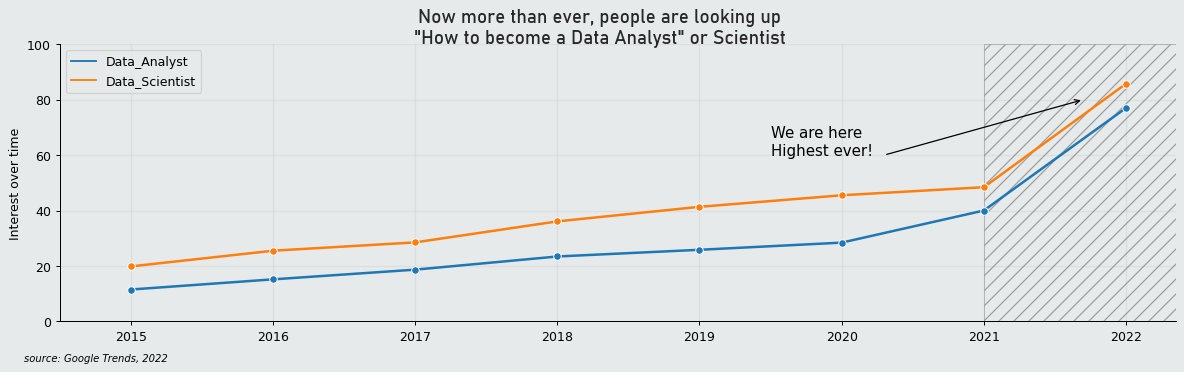

In [77]:
fig,ax = plt.subplots(figsize = (16,4), dpi=90)
fig.set_facecolor(BG)
ax.set_facecolor(BG)

sns.lineplot(data=quick_pivot, x=quick_pivot.Month.dt.year, y='value', hue='Element', errorbar=None, lw=2, marker='o', ax=ax,)

ax.set_ylim(0,100)
ax.set_xlim(ax.get_xticks().min()+0.5)

# ax.spines.left.set_visible(False)
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)

# de-clutter from obvious information

ax.set_xlabel('')
ax.set_ylabel('Interest over time')

plt.suptitle('Now more than ever, people are looking up\n"How to become a Data Analyst" or Scientist', fontsize=15, fontname='Bahnschrift', weight='bold', color=HEAL[2])
plt.title('', fontsize=25, fontname='Bahnschrift', weight='bold', loc='center', color=HEAL[2])

# x_ticks and y_ticks are more often than not, Not of the same size,
# For that reason we cannot zip them  & add lines individually

for x in ax.get_yticks():
    ax.axhline(x, lw=1, color='grey', alpha=0.1, zorder=0)
for x in ax.get_xticks():
    ax.axvline(x, lw=1, color='grey', alpha=0.1, zorder=0)

ax.add_patch(
    Rectangle(
    (2021,0), 2, 100, facecolor='none', hatch='//', edgecolor='grey', lw= 0.5, zorder=0, alpha=0.7,
    )
)
ax.text(
    2019.5,60, 'We are here\nHighest ever!', fontsize=12, ha='left',
)
ax.annotate('', xy=(2020.3, 60), xytext=(2021.7, 80),
            arrowprops=dict(arrowstyle="<-"))

plt.figtext(0.1, 0, 'source: Google Trends, 2022', wrap=True, horizontalalignment='left', fontsize=8, style='oblique')

ax.legend(labels=['Data Analyst','Data Scientist'])
ax.legend(loc='upper left', facecolor=BG)
plt.show()

___

<center>
<a href="https://hbr.org/2012/10/data-scientist-the-sexiest-job-of-the-21st-century" rel="some text"><img src="https://imgur.com/9fhg4wC.jpg" width="800"/></a></center>

___

### <div style="font-family: Trebuchet MS; background-color: #272628; color: #FFFFFF; padding: 20px; line-height: 1.5;">Are companies seeking more Analysts or is it Kaggle only?</div>  
#### <div style="font-family: Trebuchet MS; background-color: #ffffff; color: #000000; padding: 12px; line-height: 1.5;">Data in the 21st Century is like Oil in the 18th Century: an immensely, untapped valuable asset. Like oil, for those who see Data’s fundamental value and learn to extract and use it there will be huge rewards.<br>We’re in a digital economy where data is more valuable than ever. It’s the key to the smooth functionality of everything from the government to local companies. Without it, progress would halt.</div>  
<div style="font-family: Trebuchet MS; background-color: #6FA4B5; color: #FFFFFF; padding: 10px; line-height: 1;">-Wired[4]</div>  
  
<br>
In the long term, it would probably be unwise to bet against data science as career move, especially when you widen the field to include related positions like research engineers and machine learning engineers. <b>The U.S. Bureau of Labor Statistics sees strong growth for data science jobs skills in its prediction that the data science field will grow about 28% through 2026</b>. Also, as technology improves, companies have been able to increase the sophistication of their data operations and analysis. Increasingly, that means inserting artificial intelligence (AI) capabilities into the business processes of regular companies (i.e. non-tech giants). And that means demand for data scientists (average salary in USA $111,100) and related positions (research scientists and machine learning engineer will also go up. While the tools are getting better, data scientists looking to accel in the marketplace will still need to have a solid understanding of the basics, including data modeling, relational databases, and basic statistical analysis. Those are critical skills that are likely to survive any future shifts in data science job functions.<br>
<b>-Bernhard Schroeder, Forbes</b>[9]

___

In [78]:
demo = fetch_ts([df_20, df_21, df_22], 27, year=['2020','2021', '2022'])
demo = demo.groupby([demo.Year,demo.Element]).agg({'Percent_of_respondents':'sum'}).reset_index().sort_values(by='Percent_of_respondents', ascending=False)
demo_d = demo[demo.Element.str.contains(pat='Data')]

In [79]:
demo_d['Role'] = demo_d.apply(lambda row: give_me_role(row), axis=1)
demo_d = demo_d.groupby(['Year','Role'])['Percent_of_respondents'].sum().reset_index()
demo_d['Year_Sum'] = demo_d.apply(lambda row: share_of_year(row, demo_d), axis=1)

In [80]:
category_names = demo_d['Role'].unique()

distribution_values = {}
# For every Year -> For every Role's value
for year in demo_d['Year'].unique():
    temp_list = []
    for role in demo_d['Role'].unique():
        temp_list.append(
            demo_d[(demo_d['Year']==year) & (demo_d['Role']==role)].Year_Sum.values[0]
        )
    distribution_values[year] = temp_list

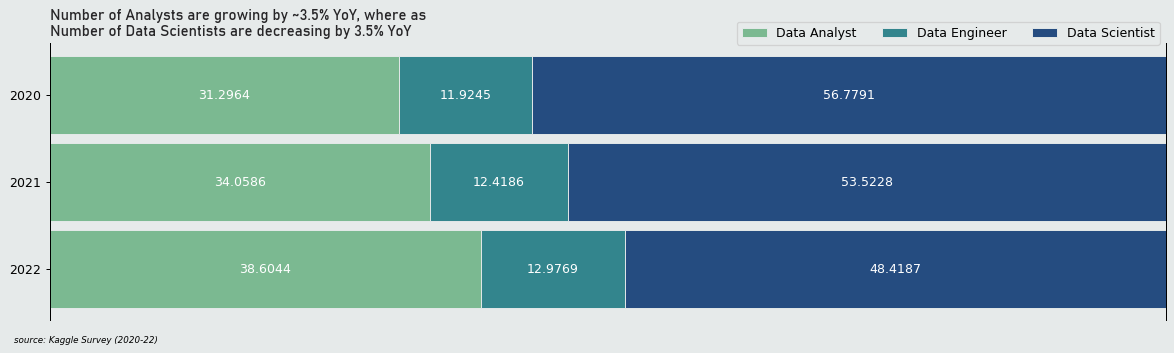

In [81]:
fig, ax = plt.subplots(figsize = (16,4), dpi=90)
fig.set_facecolor(BG)
ax.set_facecolor(BG)
discrete_distribution_horizontal(distribution_values, category_names, cmap='crest')

# plt.suptitle('Data Analysts have a highet growth Rate', fontsize=15, fontname='Bahnschrift', weight='bold', color=HEAL[2])
plt.title('Number of Analysts are growing by ~3.5% YoY, where as\nNumber of Data Scientists are decreasing by 3.5% YoY', fontsize=12, fontname='Bahnschrift', weight='bold', loc='left', color=HEAL[2])
plt.figtext(0.1, 0.05, 'source: Kaggle Survey (2020-22)', wrap=True, horizontalalignment='left', fontsize=7, style='oblique')

ax.legend(loc='upper right',bbox_to_anchor=(1, 1.1), facecolor=BG, ncol=3)
plt.show()

___

<center>
<a href="https://hbr.org/2012/10/data-scientist-the-sexiest-job-of-the-21st-century" rel="some text"><img src="https://imgur.com/oKJQX89.jpg" width="1100"/></a></center>

___

### <div style="font-family: Trebuchet MS; background-color: #272628; color: #FFFFFF; padding: 20px; line-height: 1.5;">Fast Forward from 2020 to 2022, Effect of Post Covid</div>  

<div style="font-family: Trebuchet MS; background-color: #ffffff; color: #000000; padding: 12px; line-height: 1.5;"><b>"COVID-19 is upending data analytics practices, sidelining predictive analytics, and driving firms to external data and other economic indicators."</b><br>- MIT.edu<br>A representative also mentioned, <b>"if the past is no longer a guide to the future, we’re going to have a tough time doing any sort of predictive analytics.”</b><br>For that reason, Firms are reverting to descriptive analytics and pausing machine learning, That could be one possible explanation for the increase in demand for Data analysts.<br><b>"The simplest predictive model is what happened yesterday"</b><br>- MIT.edu representative [10]</div>

In [82]:
# Use of ML vs No / Do not know Use of ML over the years, The gap is of concern isn't it

use_of_ml = fetch_ts([df_18, df_19, df_20, df_21, df_22], 31, ['2018', '2019', '2020','2021', '2022'], merge=False, append_year=False)

reported_use_of_ml = use_of_ml[~use_of_ml.Element.isin(['No (we do not use ML methods)','I do not know'])]
reported_use_of_ml['Element'] = 'Incorporate ML at some level'
no_use_of_ml = use_of_ml[use_of_ml.Element.isin(['No (we do not use ML methods)','I do not know'])]
no_use_of_ml['Element'] = 'Do not use or know'

reported_use_of_ml = reported_use_of_ml.groupby([reported_use_of_ml.Year, reported_use_of_ml.Element]).agg({'Percent_of_respondents':'mean'}).reset_index()
no_use_of_ml = no_use_of_ml.groupby([ no_use_of_ml.Year, no_use_of_ml.Element]).agg({'Percent_of_respondents':'mean'}).reset_index()

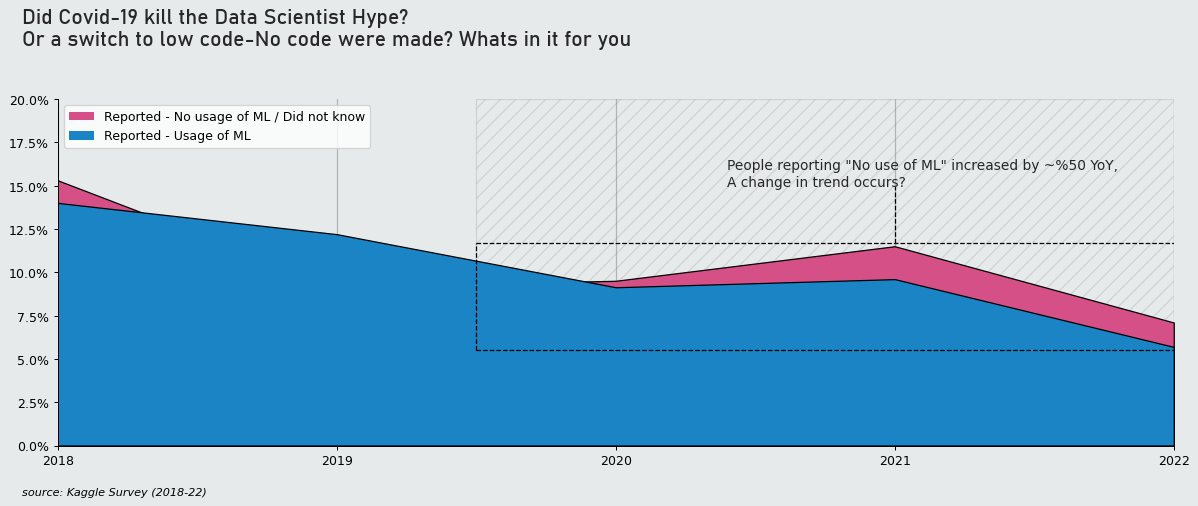

In [83]:
fig, ax = plt.subplots(figsize=(16,5), dpi=90)
fig.set_facecolor(BG)
ax.set_facecolor(BG)

ax.set_xlim(0,4) # Edge to edge fill
ax.set_ylim(0,20)

_ = plt.fill_between(no_use_of_ml.Year, no_use_of_ml.Percent_of_respondents, color=CMAP_PALLET[4], zorder=1, edgecolor='black', lw=1)
_ = plt.fill_between(reported_use_of_ml.Year, reported_use_of_ml.Percent_of_respondents, color=STA_HEATMAP[3], alpha = 1, zorder=2, edgecolor='black', lw=1)

ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())

ax.add_patch(
        Rectangle(
            (1.5,0), 2.5, 20, facecolor=BG, zorder=0, hatch='//', edgecolor='black', lw=1, alpha=0.1,
        ) )

plt.figtext(0.1, 0, 'source: Kaggle Survey (2018-22)', wrap=True, horizontalalignment='left', fontsize=9, style='oblique')
plt.figtext(0.1, 1,'Did Covid-19 kill the Data Scientist Hype?\nOr a switch to low code-No code were made? Whats in it for you', fontsize=17, fontname='Bahnschrift', weight='bold', color=HEAL[2])

ax.text(2.4, 15, 'People reporting "No use of ML" increased by ~%50 YoY,\nA change in trend occurs?', color=HEAL[2], fontsize=11, weight='light')

# Adapted from > https://matplotlib.org/stable/gallery/text_labels_and_annotations/custom_legends.html
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=CMAP_PALLET[4], label='Reported - No usage of ML / Did not know'),
                Patch(facecolor=STA_HEATMAP[3], label='Reported - Usage of ML')]
ax.legend(handles=legend_elements, loc='upper left')

for x in ax.get_xticks():
    ax.axvline(x, lw=1, color='grey', alpha=0.5, zorder=0)

ax.hlines(5.5, 1.5, 4, lw=1, color='black', ls='--')
ax.hlines(11.7, 1.5, 4, lw=1, color='black', ls='--')
ax.vlines(1.5, 5.5, 11.7, lw=1, color='black', ls='--')
ax.vlines(3, 11.7, 15, lw=1, color='black', ls='--')
plt.show()

___

In [84]:
use_of_ml = fetch_ts_by_category(frames=[df_18, df_19, df_20, df_21, df_22], year=['2018', '2019', '2020','2021', '2022'], cat_query=3, ele_query=31)

# remove 'Other' country
use_of_ml = use_of_ml[~(use_of_ml['Category'] == 'Other')]
use_of_ml = use_of_ml[~(use_of_ml['Category'] == 'I do not wish to disclose my location')]

use_of_ml.Category.replace(['Iran, Islamic Republic of...','United Kingdom of Great Britain and Northern Ireland','Hong Kong (S.A.R.)','Republic of Korea'], ['Iran','United Kingdom','Hong Kong','South Korea'], inplace=True)

use_of_ml['Continent'] = use_of_ml.apply(convert, axis=1)
use_of_ml['Continent'] = use_of_ml['Continent'].map(conti_names)

In [85]:
use_ml = use_of_ml[~use_of_ml.Element.isin(['No (we do not use ML methods)','I do not know'])]
use_ml['Element'] = 'Incorporate ML at some level'
dont_use_ml = use_of_ml[use_of_ml.Element.isin(['No (we do not use ML methods)','I do not know'])]
dont_use_ml['Element'] = 'Do not use or know'

In [86]:
use_ml = use_ml.groupby([use_ml.Continent, use_ml.Element]).agg({'Percent_of_respondents':'mean'}).reset_index() #'Value':'sum', 'Percent_of_respondents':'sum'
dont_use_ml = dont_use_ml.groupby([ dont_use_ml.Continent, dont_use_ml.Element]).agg({'Percent_of_respondents':'mean'}).reset_index() # 'Value':'sum', 'Percent_of_respondents':'sum'

use_ml['change'] = use_ml['Percent_of_respondents'].pct_change()
use_ml.fillna(0, inplace=True)
use_ml.rename({'Percent_of_respondents':'Value'}, axis=1, inplace=True)
dont_use_ml['change'] = dont_use_ml['Percent_of_respondents'].pct_change()
dont_use_ml.fillna(0, inplace=True)
dont_use_ml.rename({'Percent_of_respondents':'Value'}, axis=1, inplace=True)

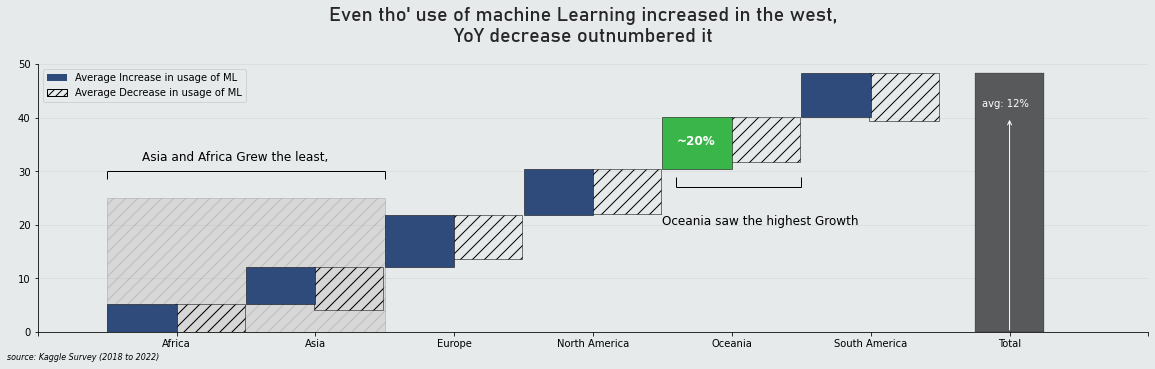

In [87]:
fig,ax = plt.subplots(tight_layout=True , figsize=(16,5), dpi=72)
fig.set_facecolor(BG)

# Top plot
ax.set_facecolor(BG)
wc_group([use_ml, dont_use_ml], len(use_ml), 50, 100, x_tick_to_set=use_ml.Continent, ax=ax, bar_color = CMAP_PALLET[1])

# ax.spines.left.set_visible(False)
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
# ax.get_yaxis().set_visible(False)

## Annotations
ax.add_patch(
    Rectangle(
    (0.5,0),2,25, facecolor=GREY_LIGHT, zorder=-1, alpha = 0.3, hatch='//', edgecolor='grey', lw=1,
    )
)

plt.suptitle("Even tho' use of machine Learning increased in the west,\nYoY decrease outnumbered it", fontsize=20, fontname='Bahnschrift', weight='bold', color=HEAL[2])
plt.title('', fontsize=25, fontname='Bahnschrift', weight='bold', loc='center', color=HEAL[2])

ax.text(0.75,32, 'Asia and Africa Grew the least,', fontsize=12)
ax.hlines(30, 0.5, 2.5, lw=1, color='black')
ax.vlines(0.5, 28.5, 30, lw=1, color='black')
ax.vlines(2.5, 28.5, 30, lw=1, color='black')

for x in ax.get_yticks():
    ax.axhline(x, lw=1, color='grey', alpha=0.1, zorder=0)

ax.annotate('', xy=(7, 0), xytext=(7, 40),
            arrowprops=dict(arrowstyle="<-", color='white'))

ax.text(6.8,42,'avg: 12%', color='white')
plt.figtext(0., 0, 'source: Kaggle Survey (2018 to 2022)', wrap=True, horizontalalignment='left', fontsize=8, style='oblique')

ax.text(4.5,20, 'Oceania saw the highest Growth', fontsize=12)
ax.text(4.6,35, '~20%', color='white', fontsize=12, weight='heavy')
ax.hlines(27, 4.6, 5.5, lw=1, color='black')
ax.vlines(4.6, 27, 29, lw=1, color='black')
ax.vlines(5.5, 27, 29, lw=1, color='black')

legend_elements = [Patch(facecolor=CMAP_PALLET[1], label='Average Increase in usage of ML'),
                Patch(facecolor='none', hatch='///', edgecolor='black', lw=1,  label='Average Decrease in usage of ML')]
ax.legend(handles=legend_elements, loc='upper left', facecolor=BG)
plt.show()

___
### <div style="font-family: Trebuchet MS; background-color: #272628; color: #FFFFFF; padding: 20px; line-height: 1.5;">From Tech Boom to Tech Gloom?</div>  

<div style="font-family: Trebuchet MS; background-color: #FFFFFF; color: #000000; padding: 12px; line-height: 1.5;">2021 was the safest year, but the futre does'nt look like. One of the biggest reasons of Layoffs looks to be "Economic Uncertainty",<br>An article from Makeuseof.com reads<br>
    <blockquote cite="https://www.makeuseof.com/why-tech-companies-laying-off-employees/">
        <p>Unusual and Uncertain macroeconomic environment" that led to its decision to lose "talented Amazonians." The New York Times reports that Amazon has since pared back its workforce to almost 80,000 from April to September, with thousands more expected to be laid off in the coming days.<br>

Debates about whether the U.S. is in a recession escalated after data from the U.S. Bureau of Economic Analysis in July 2022 showed a shrinking economy for the second straight quarter. You can't confidently say that the future looks rosy. The International Monetary Fund (IMF) states that economic conditions hang in a balance, depending on the course of the war in Ukraine, monetary policy, and the pandemic. You can conclude that layoffs are a company's way to survive uncertain times.</p>
    </blockquote></div>

___

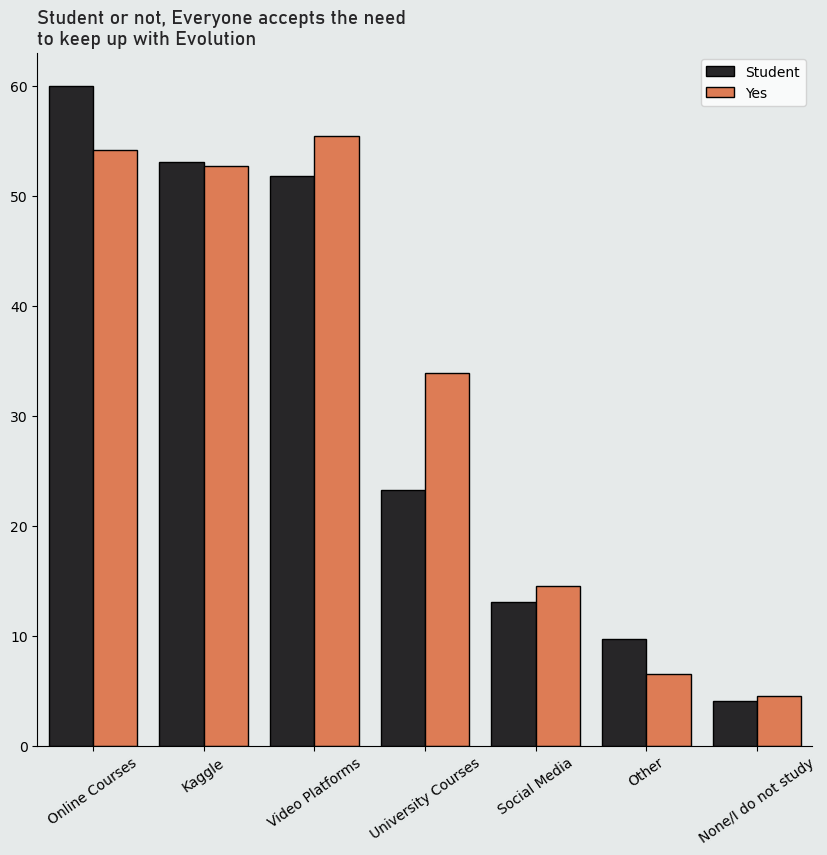

In [88]:
# First ask in 2022
platform_by_student = fetch_ts_by_category(frames=[df_22], year=['2022'], cat_query=4, ele_query=6)

fig, ax = plt.subplots(figsize=(10,9))
ax.set_facecolor(BG)
fig.set_facecolor(BG)

s = sns.barplot(data=platform_by_student, x='Element', y='Percent_of_respondents', hue='Category', palette=[HEAL[2], HEAL[4]], edgecolor='black', lw=1)
# show_values(s, space=0.13)

labels = ['Online Courses', 'Kaggle', 'Video Platforms', 'University Courses', 'Social Media', 'Other', 'None/I do not study']
ax.set_xticklabels(labels)

legend_vals=plt.legend()
legend_vals.get_texts()[0].set_text('Not a Student')
legend_vals.get_texts()[0].set_text('Student')

plt.xticks(rotation=35)
ax.spines.top.set_visible(False)
ax.spines.right.set_visible(False)
ax.set_xlabel('')
ax.set_ylabel('')

plt.title('Student or not, Everyone accepts the need\nto keep up with Evolution', loc='left', fontsize=14, ha='left', fontname='Bahnschrift', weight='bold', color=HEAL[2])
plt.show()

### <div style="font-family: Trebuchet MS; background-color: #272628; color: #FFFFFF; padding: 20px; line-height: 1.5;">The Bare minimum to step foot into the Jungle</div>  
<div style="font-family: Trebuchet MS; background-color: #6FA4B5; color: #FFFFFF; padding: 12px; line-height: 1.5;">As said by the hundreds of articles and thousands of professionals, The stepping stone in the field of Data is-<br><b>A. Learn a Data Manipulation Language<br>B. Learn a way to analyze and communicate insights</b><br><br>We'll have a quick overview on few thousands of Job Descriptions (approx 2000) which have been scrapped from the web with love for you, we'll try to figure out which crucial deficit can we fill in to fight upcoming times of uncertainity</div>

___

In [89]:
# Supply vs Demand
kw_pgm = pd.read_csv('DataSources/Keywords/kw_programming.csv', usecols=['keywords', 'counts', 'percentage'])
kw_pgm['val'] = 'Chances of beign in Job Description'

pgm = fetch_ts([df_22], 12, year=['2022'], merge=False, append_year=False)

In [90]:
# Programming Languages
pgm = fetch_ts([df_22], 12, year=['2022'], merge=False, append_year=False)
pgm_rec = fetch_ts([df_20, df_21], 13, year=['2020', '2021'], merge=False, append_year=False).groupby('Element')['Percent_of_respondents'].mean().reset_index().sort_values(by='Percent_of_respondents', ascending=False)

pgm['val'] = 'What kagglers use regularly'
pgm['lower'] = pgm['Element'].str.lower()

pgm_rec['val'] = 'What Kagglers recommend learning first'
pgm_rec['lower'] = pgm_rec['Element'].str.lower()

In [91]:
pgm = pgm[['Element','Percent_of_respondents','val','lower']]

pgc = pd.concat([pgm, pgm_rec], ignore_index=True)
new_pgm = pgc.merge(kw_pgm, left_on="lower", right_on="keywords", how="left").dropna()

In [92]:
a = new_pgm[['Element', 'Percent_of_respondents', 'val_x']]

# First set 'B' cause we will replace a with a
b = a[a.val_x == 'What Kagglers recommend learning first']
a = a[a.val_x == 'What kagglers use regularly']

c = new_pgm[['Element', 'percentage', 'val_y']]
c.rename({'percentage':'Percent_of_respondents', 'val_y':'val_x'}, axis=1, inplace=True)
c.drop_duplicates(inplace=True)

In [93]:
pgm_final = pd.concat([b,a,c], ignore_index=True)

# Why top 3 ?
# Cause average learner doesnt learn more than 2 / 3

top_5 = list(
        pgm_final.groupby('Element')['Percent_of_respondents'].sum().reset_index().sort_values(by='Percent_of_respondents', ascending=False)['Element'][:3].values )
pgm_final = pgm_final[pgm_final['Element'].isin(top_5)]

In [94]:
kw_bi = pd.read_csv('DataSources/Keywords/kw_bi.csv', usecols=['keywords', 'counts', 'percentage'])
kw_bi.keywords.replace(['power_bi','tableau','looker'], ['Microsoft Power BI','Tableau','Looker'], inplace=True)
kw_bi['val'] = 'Chances of beign in Job Description'
kw_bi.rename({'keywords':'Element','percentage':'Percent_of_respondents'}, axis=1, inplace=True)

In [95]:
# BI Tools [44, 45], Fetch2x
use_of_bi = fetch_ts([df_22], 45, year=['2022'], merge=False, append_year=False)

In [96]:
use_of_bi['val'] = 'What kagglers use regularly'
temp_use_of_bi_22 = use_of_bi[ use_of_bi['Element'].isin(kw_bi.Element.unique()) ]

use_of_bi_final = pd.concat([temp_use_of_bi_22, kw_bi], ignore_index=True) # We need Element, PCT

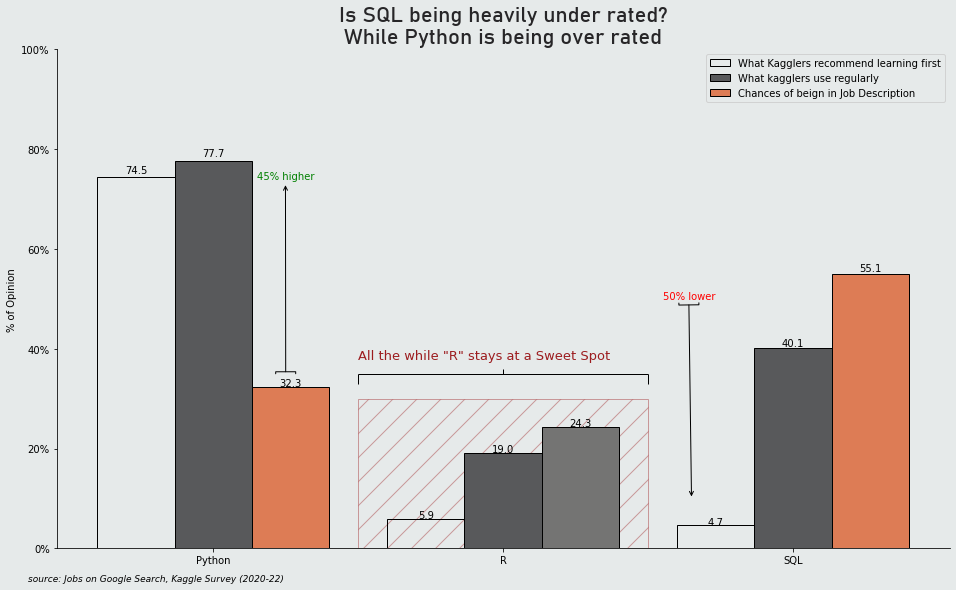

In [97]:
fig, ax = plt.subplots(figsize = (16,9), dpi=72)
fig.set_facecolor(BG)

s = sns.barplot(data=pgm_final, x='Element', y='Percent_of_respondents', hue='val_x', palette=[STA_HEATMAP[0], HEAL[1], HEAL[4]], lw=1, edgecolor='black', ax=ax)
show_values(s, space=1)

ax.set_facecolor(BG)
ax.set_facecolor(BG)

ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)

for x, patch in enumerate(ax.patches) :
        if x in [0,1,2]:
            patch.set_color('None')
            patch.set_capstyle('round')
            patch.set_edgecolor('black')
            patch.set_linewidth(1)

ax.set_xlabel('')
ax.set_ylabel('% of Opinion')
ax.set_ylim(0,100)

ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.legend(title=False, facecolor=BG)

ax.annotate('45% higher', xy=(0.25, 35), xytext=(0.15, 74), arrowprops=dict(arrowstyle='<-['), zorder=3, color='green')
ax.annotate('50% lower', xy=(1.65, 10), xytext=(1.55, 50), arrowprops=dict(arrowstyle=']->'), zorder=3, color='red')
plt.title('Is SQL being heavily under rated?\nWhile Python is being over rated', fontsize=22, fontname='Bahnschrift', weight='bold', loc='center', color=HEAL[2])

ax.add_patch( Rectangle((0.5,0), 1,30, facecolor='none', hatch='/', edgecolor=HEAL[5], zorder=0, alpha=0.4)   )
ax.text( 0.5, 38, 'All the while "R" stays at a Sweet Spot', fontsize=13, color=HEAL[5], weight='light')

ax.hlines(35, 0.5, 1.5, lw=1, color='black')
ax.vlines(0.5, 33, 35, lw=1, color='black')
ax.vlines(1.5, 33, 35, lw=1, color='black')
ax.vlines(1, 35, 36, lw=1, color='black')

plt.figtext(0.1, 0.06, 'source: Jobs on Google Search, Kaggle Survey (2020-22)', wrap=True, horizontalalignment='left', fontsize=9, style='oblique')

ax.patches[7].set_color(GREY_DARK)
ax.patches[7].set_edgecolor('black')
ax.patches[7].set_linewidth(1)

### <div style="font-family: Trebuchet MS; background-color: #272628; color: #FFFFFF; padding: 20px; line-height: 1.5;">Why is this difference so large?</div>  
##### <div style="font-family: Trebuchet MS; background-color: #FFFFFF; color: #000000; padding: 12px; line-height: 1.5;"><b>Kagglers use Python a lot!</b><br>It looks like if we head into an interview room together, and all we were asked about was Python in Data Science, We would ace it,<br>But can we say the same about SQL? It has a higher probability of being in a Job Description, In fact the most!<br> <b>Less than 10% of Kagglers recommend SQL to learn first,</b> Is it because <u>Python is easier to use and manipulate Dataframes? or Python does the job of Visualizing as well</u></div>  

<center>
<img src="https://imgur.com/r0ASRS9.gif" width="500"/><br>cropped from Luke Barousse process explanation, more in references</center>

___

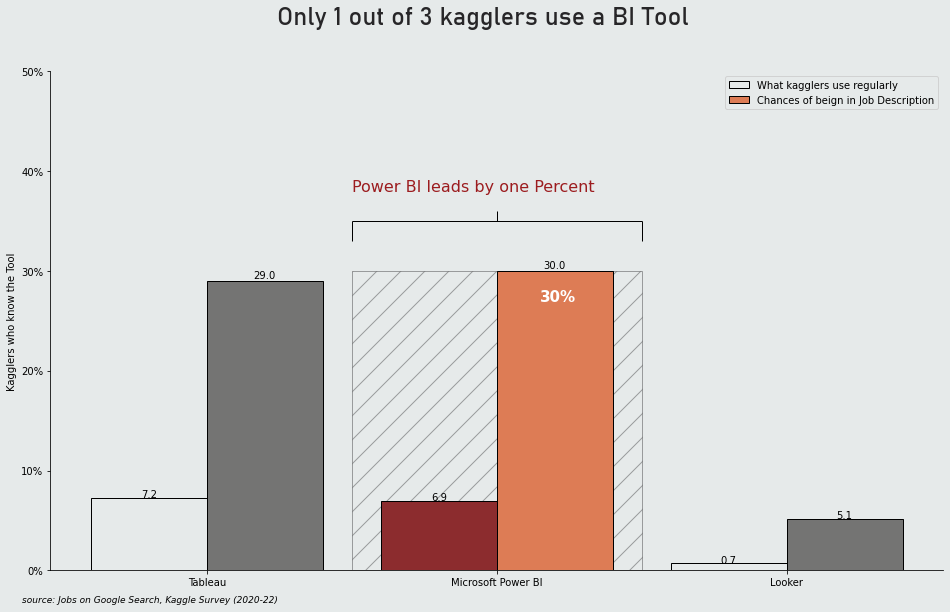

In [98]:
fig, ax = plt.subplots(figsize = (16,9), dpi=72)
fig.set_facecolor(BG)
ax.set_facecolor(BG)

b = sns.barplot(data=use_of_bi_final, x='Element', y='Percent_of_respondents', hue='val', palette=[HEAL[5], HEAL[4]], lw=1, edgecolor='black', ax=ax)
show_values(b, space=0.05)
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)

for x, patch in enumerate(ax.patches) :
        if x in [0,1,2]:
            if x!= 1:
                patch.set_color('None')
            patch.set_capstyle('round')
            patch.set_edgecolor('black')
            patch.set_linewidth(1)

ax.set_xlabel('')
ax.set_ylabel('Kagglers who know the Tool')
ax.set_ylim(0,50)

ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.legend(title=False, facecolor=BG)

# ax.annotate('45%', xy=(0.25, 35), xytext=(0.215, 74), arrowprops=dict(arrowstyle=']-['), zorder=3)
# ax.annotate('50%', xy=(1.75, 10), xytext=(1.72, 50), arrowprops=dict(arrowstyle=']-['), zorder=3)
plt.suptitle('Only 1 out of 3 kagglers use a BI Tool', fontsize=25, fontname='Bahnschrift', weight='bold', color=HEAL[2])
plt.title('', fontsize=25, fontname='Bahnschrift', weight='bold', loc='center', color=HEAL[2])
plt.figtext(0.1, 0.06, 'source: Jobs on Google Search, Kaggle Survey (2020-22)', wrap=True, horizontalalignment='left', fontsize=9, style='oblique')

ax.add_patch( Rectangle((0.5,0), 1,30, facecolor='none', hatch='/', edgecolor=HEAL[2], zorder=0, alpha=0.4)   )
ax.text( 0.5, 38, 'Power BI leads by one Percent', fontsize=16, color=HEAL[5])
ax.text(1.15, 27, '30%', color='white', fontsize=15, weight='bold')

ax.hlines(35, 0.5, 1.5, lw=1, color='black')
ax.vlines(0.5, 33, 35, lw=1, color='black')
ax.vlines(1.5, 33, 35, lw=1, color='black')
ax.vlines(1, 35, 36, lw=1, color='black')

for x in [3,5]:
    ax.patches[x].set_color(GREY_DARK)
    ax.patches[x].set_edgecolor('black')
    ax.patches[x].set_linewidth(1)

### <div style="font-family: Trebuchet MS; background-color: #272628; color: #FFFFFF; padding: 20px; line-height: 1.5;">Would Kagglers ace low code - no code requirements</div>  
#### <div style="font-family: Trebuchet MS; background-color: #FFFFFF; color: #000000; padding: 12px; line-height: 1.5;">Low Code / No Code tools have been trend and is making it now more easier than ever for an individual to ride the tide of Data,<br>However its not recommended as much as Python or SQL. Only around 1 out of 10 Kagglers make use of BI Tools where as 3 out of 10 Jobs would require it.<br>Knowing a BI Tools would help you fill this Gap easily (if you dont already)</div>  

___

In [99]:
# 2x Drop fail cus the row 'None' doesnt exist
cc_platform = learning_curve([df_20, df_21], [35, 36], year=['2020','2021',])
cc_Product = learning_curve([df_20, df_21], [38, 39], year=['2020','2021',])
data_storage = learning_curve([df_20, df_21], [40, 41], year=['2020','2021',])
big_data_products = learning_curve([df_20, df_21], [42, 43], year=['2020','2021',])
bi_tools = learning_curve([df_20, df_21], [44, 45], year=['2020','2021',])

Drop fail
Drop fail


<center>
<img src="https://imgur.com/UPIZLX8.jpg" width="500"/><br>
<a href="https://www.kaggle.com/code/iamleonie/head-in-the-clouds/notebook" rel="some text"><img src="https://imgur.com/UnuLQBZ.jpg" width="800"/></a></center>

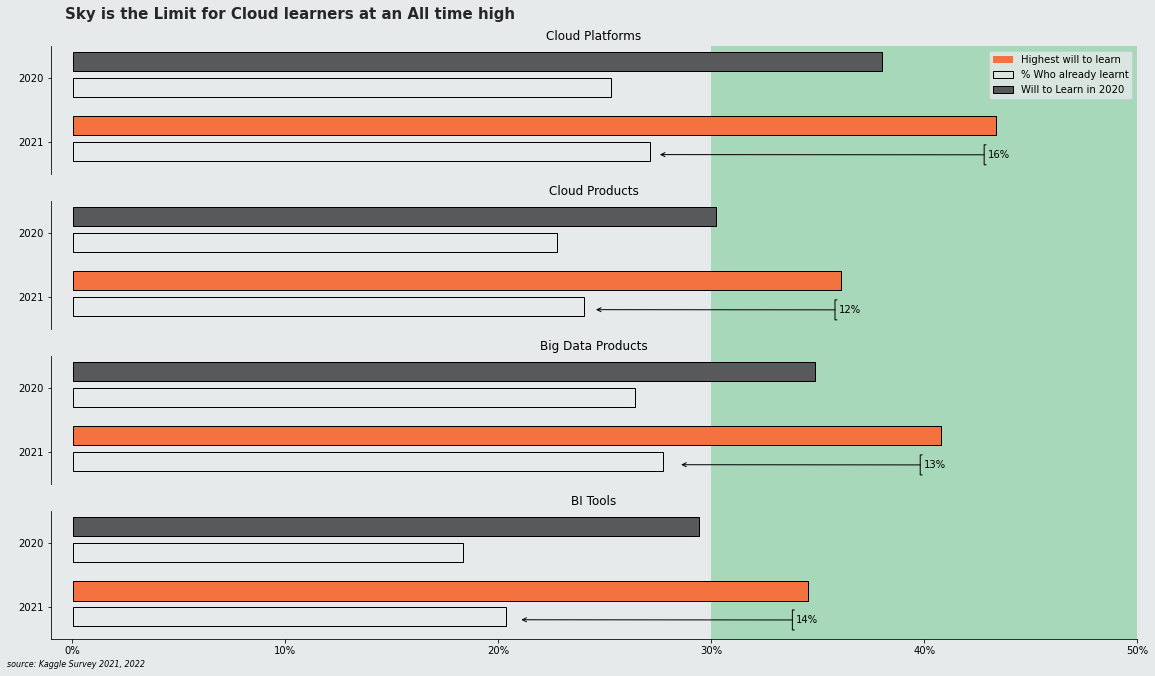

In [100]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, tight_layout=True, sharex=True, figsize=(16,9), dpi=72)

sns.barplot(data=cc_platform, x='Value', y='Year', hue='Element', ax=ax1, palette=[HEAL[4], HEAL[0]], zorder=2,).set(title='Cloud Platforms')
sns.barplot(data=cc_Product, x='Value', y='Year', hue='Element', ax=ax2, zorder=2).set(title='Cloud Products')
sns.barplot(data=big_data_products, x='Value', y='Year', hue='Element', ax=ax3, zorder=2).set(title='Big Data Products')
sns.barplot(data=bi_tools, x='Value', y='Year', hue='Element', ax=ax4, zorder=2).set(title='BI Tools')

ax1.set_xlim(-1,50)

axes_list = [ax1, ax2, ax3, ax4]

# Shrinking the Bars a bit, Helps the reader to diffrentiate a bit more easily
# Adapted from
# https://stackoverflow.com/questions/34888058/changing-width-of-bars-in-bar-chart-created-using-seaborn-factorplot

shrink_value = 0.3
for ax in axes_list:
    for x, patch in enumerate(ax.patches) :
        if x in [2,3]:
            patch.set_color('None')
            patch.set_capstyle('round')
        if x == 1:
            patch.set_color(HEAL[4])
        if x == 0:
             patch.set_color(HEAL[1])
        patch.set_edgecolor('black')
        patch.set_linewidth(1)
        current_width = patch.get_height()
        diff = current_width - shrink_value

        patch.set_height(shrink_value)
        patch.set_x(patch.get_x() + diff * .5)

xmin = [30]#, 40]
xmax = [50]#, 50]

# Adapted from
# https://stackoverflow.com/questions/62991535/how-to-draw-a-rectangular-on-subplotted-figure-using-matlibplot-in-python
# Gets the job done asap

temp_color_val = [color_vals[1], color_vals[3]]
for i in range(0, len(xmin)): 
    min, max = xmin[i], xmax[i]
    _,top = fig.transFigure.inverted().transform(ax1.transAxes.transform([0,1]))
    _,bottom = fig.transFigure.inverted().transform(ax4.transAxes.transform([0,0]))
    trans = matplotlib.transforms.blended_transform_factory(ax1.transData, fig.transFigure)
    r = matplotlib.patches.Rectangle(xy=(min,bottom), width=max-min, height=top-bottom, transform=trans,
                                    fc=temp_color_val[i], ec='none', lw=0, zorder=0)
    fig.add_artist(r,)

for x,ax in enumerate(axes_list):
    ax.set_facecolor(BG)
    ax.set_xlabel('')
    ax.set_ylabel('')
    if x > 0:
        ax.get_legend().remove()
    ax.spines.bottom.set_visible(False)
    ax.spines.right.set_visible(False)
    ax.spines.top.set_visible(False)
    ax.get_xaxis().set_visible(False)
    ax.xaxis.set_major_formatter(mtick.PercentFormatter())
    
    ax.add_patch(
        Rectangle(
            (30,-1), 20, 3, facecolor=color_vals[1],
        ) )

fig.set_facecolor(BG)
ax4.spines.bottom.set_visible(True)
ax4.get_xaxis().set_visible(True)

legend_elements = [Patch(facecolor=HEAL[4], label='Highest will to learn'),
                   Patch(facecolor='none', edgecolor='black', lw=1,  label='% Who already learnt'),
                   Patch(facecolor=HEAL[1], edgecolor='black', lw=1,  label='Will to Learn in 2020')]
ax1.legend(handles=legend_elements, loc='upper right', facecolor=BG)

ax1.annotate('16%', xy=(27.5, 1.2), xytext=(43, 1.25), arrowprops=dict(arrowstyle=']->'), zorder=3)
ax2.annotate('12%', xy=(24.5, 1.2), xytext=(36, 1.25), arrowprops=dict(arrowstyle=']->'), zorder=3)
ax3.annotate('13%', xy=(28.5, 1.2), xytext=(40, 1.25), arrowprops=dict(arrowstyle=']->'), zorder=3)
ax4.annotate('14%', xy=(21, 1.2), xytext=(34, 1.25), arrowprops=dict(arrowstyle=']->'), zorder=3)

plt.figtext(0, 0, 'source: Kaggle Survey 2021, 2022', wrap=True, horizontalalignment='left', fontsize=8, style='oblique')
plt.figtext(0.05, 1,'Sky is the Limit for Cloud learners at an All time high', fontsize=15, fontname='sans-serif', weight='bold', color=HEAL[2])
plt.show()

### <div style="font-family: Trebuchet MS; background-color: #272628; color: #FFFFFF; padding: 20px; line-height: 1.5;">People are commited to the cloud</div>  
<div style="font-family: Trebuchet MS; background-color: #FFFFFF; color: #000000; padding: 12px; line-height: 1.5;">Around 25% of Kagglers already know one of the Cloud fronts, When Kagglers were a series of Questions about their commitments on Learning new tools, <b>On average, Around 35% of Kagglers asseerted commitment on Learning new data management tools / platforms</b>. The Learners group was highest in 2021 being on an average <b>14% Higher</b> than the group who already knew that skill. Concludingly, We can say, the learners group is bigger and we could see significant growth in the number of cloud practitioners in the future. (Hopefully through kaggles own surveys)</div>  
<div style="font-family: Trebuchet MS; background-color: #FFFFFF; color: #000000; padding: 12px; line-height: 1.5;"><b>By 2022, public cloud services will be essential for 90% of data and analytics innovation.</b><br>As data and analytics moves to the cloud, data and analytics leaders still struggle to align the right services to the right use cases, which leads to unnecessary increased governance and integration overhead.<br>The question for data and analytics is moving from how much a given service costs to how it can meet the workload’s performance requirements beyond the list price.<br>Data and analytics leaders need to <b>prioritize workloads that can exploit cloud capabilities and focus on cost optimization and other benefits such as change and innovation acceleration when moving to cloud.</b><br><b>-Gartner[11]</b><br>Can you think of one such Leader? Who does this job perfectly?<br>It's this platform you are reading on</div> 


___

In [101]:
spent_cc = fetch_ts_by_category(frames=[df_21, df_22], year=['2021', '2022'], cat_query=28, ele_query=41)

top_5 = list(
        spent_cc.groupby([spent_cc.Category]).agg({'Percent_of_respondents':'sum'}).reset_index().sort_values(by='Percent_of_respondents', ascending=False)['Category'][:5].values
    )

spent = spent_cc.groupby([spent_cc.Category, spent_cc.Element]).agg({'Percent_of_respondents':'sum'}).reset_index()#['Element'].agg(pd.Series.mode).reset_index()
spent = spent[spent['Category'].isin(top_5)]

spent['Company'] = spent.apply(lambda row: give_me_company(row), axis=1)
spent = spent[~(spent['Company'] == 'None or Other')]

In [102]:
# hbar below
spent_role = fetch_ts_by_category(frames=[df_21, df_22], year=['2021', '2022'], cat_query=27, ele_query=41)
spent_role = spent_role.groupby([spent_role.Category]).agg({'Percent_of_respondents':'mean'}).reset_index().sort_values(by='Percent_of_respondents', ascending=False)
spent_role = spent_role[spent_role.Category.str.contains(pat='Data')]
spent_role.rename({'Category':'Element'}, axis=1, inplace=True)
spent_role['Role'] = spent_role.apply(lambda row: give_me_role(row), axis=1)

spent_role = spent_role.groupby([spent_role.Role])['Percent_of_respondents'].sum().reset_index()
spent_role['share'] = ( spent_role.Percent_of_respondents / spent_role.Percent_of_respondents.sum() ) * 100

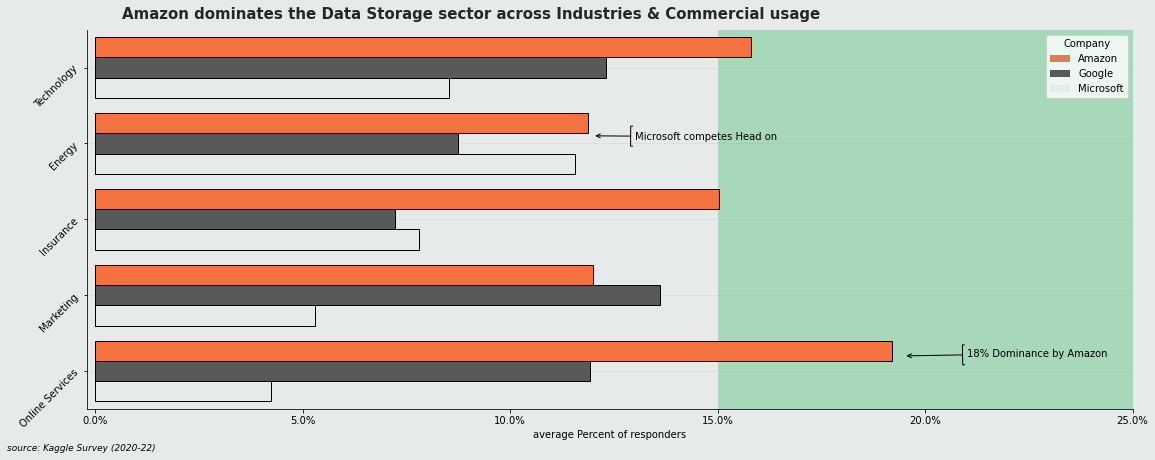

In [103]:
fig, ax = plt.subplots(figsize=(16,6), dpi=72, tight_layout=True)
fig.set_facecolor(BG)
ax.set_facecolor(BG)

sns.barplot(data=spent, x='Percent_of_respondents', y='Category', hue='Company', palette=[HEAL[4],HEAL[1],HEAL[0]], errorbar=None, ax=ax)

labels = ['Technology','Energy','Insurance','Marketing', 'Online Services']
ax.set_yticklabels(labels)

for x,patch in enumerate(ax.patches):
    if x in [0,1,2,3,4]:
        patch.set_color(HEAL[4])
    if x in [10,11,12,13,14]:
        patch.set_color('none')
    patch.set_edgecolor('black')
    patch.set_linewidth(1)

ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
ax.set_ylabel('')
ax.set_xlabel('average Percent of responders')

ax.add_patch(
        Rectangle(
            (15,-1), 10, 6, facecolor=color_vals[1], zorder=0,
        ) )

plt.yticks(rotation = 45)
plt.figtext(0, 0.0, 'source: Kaggle Survey (2020-22)', wrap=True, horizontalalignment='left', fontsize=9, style='oblique')
plt.figtext(0.1, 1,'Amazon dominates the Data Storage sector across Industries & Commercial usage', fontsize=15, fontname='sans-serif', weight='bold', color=HEAL[2])

for x in ax.get_yticks():
    ax.axhline(x, lw=1, color='grey', alpha=0.1, zorder=0)

ax.annotate('18% Dominance by Amazon', xy=(19.5, 3.8), xytext=(21, 3.81), arrowprops=dict(arrowstyle=']->'), zorder=3)
ax.annotate('Microsoft competes Head on', xy=(12, .9), xytext=(13, .95), arrowprops=dict(arrowstyle=']->'), zorder=3)

ax.xaxis.set_major_formatter(mtick.PercentFormatter())
ax.set_xlim(-0.2,25)
plt.show()

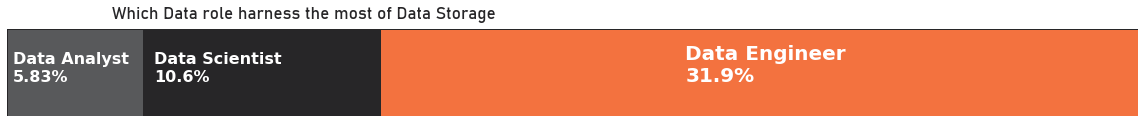

In [104]:
fig, ax = plt.subplots(figsize=(16,1.5), dpi=72, tight_layout=True)
ax.set_xlim(0,1)

ax.text(.6, 0.4, 'Data Engineer\n31.9%', color='white', fontsize=20, weight='heavy')
ax.text(.13, 0.4, 'Data Scientist\n10.6%', color='white', fontsize=16, weight='heavy')
ax.text(.005, 0.4, 'Data Analyst\n5.83%', color='white', fontsize=16, weight='heavy')

ax.add_patch(
   Rectangle(
    (0,0),1,1, facecolor=HEAL[4],edgecolor=HEAL[2], lw=1,
   )
)
ax.add_patch(
   Rectangle(
    (0,0),0.21 + 0.12 ,1, facecolor=HEAL[2],edgecolor=HEAL[2], lw=1,
   )
)
ax.add_patch(
   Rectangle(
    (0,0),0.12,1, facecolor=HEAL[1],edgecolor=HEAL[2], lw=1,
   )
)

plt.figtext(0.1, 1,'Which Data role harness the most of Data Storage', fontsize=17, fontname='Bahnschrift', weight='bold', color=HEAL[2])
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
ax.spines.bottom.set_visible(False)
ax.spines.left.set_visible(False)
ax.get_yaxis().set_visible(False)
ax.get_xaxis().set_visible(False)

### <div style="font-family: Trebuchet MS; background-color: #272628; color: #FFFFFF; padding: 20px; line-height: 1.5;">Amazon dominates overall sectors</div>  
#### <div style="font-family: Trebuchet MS; background-color: #FFFFFF; color: #000000; padding: 12px; line-height: 1.5;">Except Marketing, Google & Google Trends take the lead. With the power of Search, from reverse engineering it to find threats to finding the right customers for your product, Google has managed to make the most of their Cloud Servies.<br>By 2025, there will be over 100 zettabytes of data stored in the cloud. To put this in perspective, a zettabyte is a billion terabytes (or a trillion gigabytes).<br>In the same year, the total global data storage will exceed 200 zettabytes of data, meaning that around half of it will be stored in the cloud. By comparison, only 25 percent of all the computing data was stored this way in 2015.[7]</div>  

<center>
<img src="https://imgur.com/QBesBpZ.jpg" width="900"></center>

___

In [105]:
# Cloud Platforms

spent_cc = fetch_ts_by_category(frames=[df_21, df_22], year=['2021', '2022'], cat_query=28, ele_query=36)

top_5 = list(
        spent_cc.groupby([spent_cc.Category]).agg({'Percent_of_respondents':'sum'}).reset_index().sort_values(by='Percent_of_respondents', ascending=False)['Category'][:5].values
    )

top_5_ele = list(
        spent_cc.groupby([spent_cc.Element]).agg({'Percent_of_respondents':'sum'}).reset_index().sort_values(by='Percent_of_respondents', ascending=False)['Element'][:5].values
    )

spent = spent_cc.groupby([spent_cc.Category, spent_cc.Element]).agg({'Percent_of_respondents':'sum'}).reset_index()#['Element'].agg(pd.Series.mode).reset_index()
spent = spent[(spent['Category'].isin(top_5)) & (spent['Element'].isin(top_5_ele))]

spent['Company'] = spent.apply(lambda row: give_me_company(row), axis=1)
spent = spent[~(spent['Company'] == 'None or Other')]

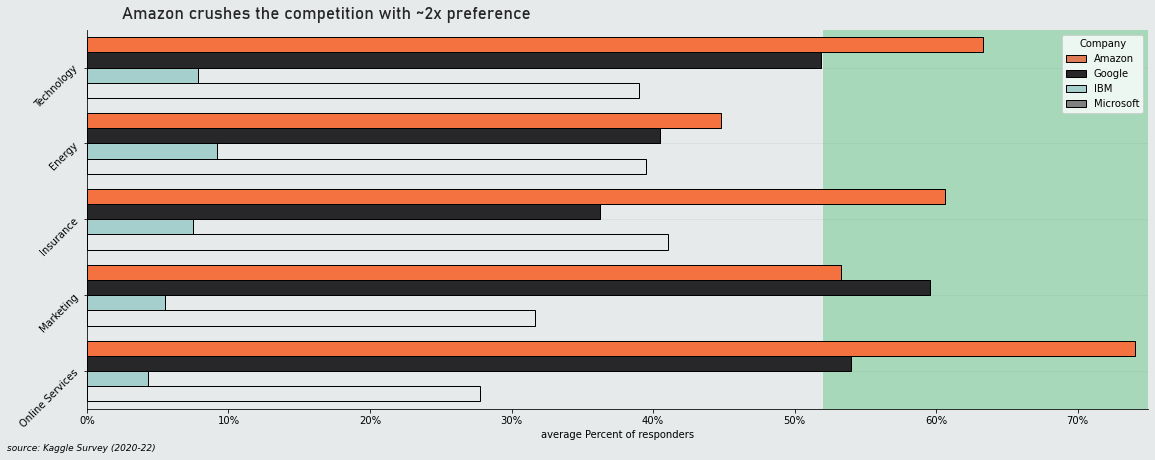

In [106]:
fig, ax = plt.subplots(figsize=(16,6), dpi=72, tight_layout=True)
fig.set_facecolor(BG)
ax.set_facecolor(BG)

sns.barplot(data=spent, x='Percent_of_respondents', y='Category', hue='Company', palette=[HEAL[4],HEAL[2],'#9DD6D2', 'grey'], errorbar=None, ax=ax, edgecolor='black', lw=1)

labels = ['Technology','Energy','Insurance','Marketing', 'Online Services']
ax.set_yticklabels(labels)

for x,patch in enumerate(ax.patches):
    if x in [0,1,2,3,4]:
        patch.set_color(HEAL[4])
    if x in [15,16,17,18,19]:
        patch.set_color('none')
    patch.set_edgecolor('black')
    patch.set_linewidth(1)

ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
ax.set_ylabel('')
ax.set_xlabel('average Percent of responders')

# Green Patch
ax.add_patch(
        Rectangle(
            (52,-1), 23, 6, facecolor=color_vals[1], zorder=0,
        ) )

plt.yticks(rotation = 45)
plt.figtext(0, 0.0, 'source: Kaggle Survey (2020-22)', wrap=True, horizontalalignment='left', fontsize=9, style='oblique')
plt.figtext(0.1, 1,'Amazon crushes the competition with ~2x preference', fontsize=17, fontname='Bahnschrift', weight='bold', color=HEAL[2])

for x in ax.get_yticks():
    ax.axhline(x, lw=1, color='grey', alpha=0.1, zorder=0)    

ax.xaxis.set_major_formatter(mtick.PercentFormatter())
ax.set_xlim(0,75)
plt.show()

In [107]:
role_share = fetch_ts_by_category(frames=[df_21, df_22], year=['2021', '2022'], cat_query=27, ele_query=36)
role_share = role_share.groupby([role_share.Category]).agg({'Percent_of_respondents':'mean'}).reset_index().sort_values(by='Percent_of_respondents', ascending=False)

role_share = role_share[role_share.Category.str.contains(pat='Data')]

role_share.rename({'Category':'Element'}, axis=1, inplace=True)

role_share['Role'] = role_share.apply(lambda row: give_me_role(row), axis=1)

role_share = role_share.groupby([role_share.Role])['Percent_of_respondents'].sum().reset_index()
role_share['share'] = ( role_share.Percent_of_respondents / role_share.Percent_of_respondents.sum() ) * 100

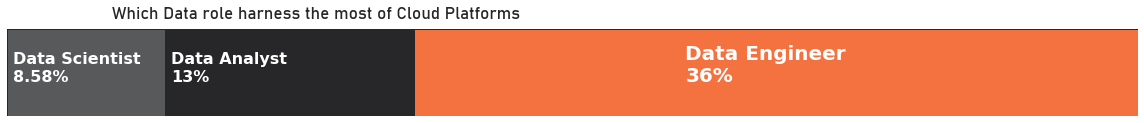

In [108]:
fig, ax = plt.subplots(figsize=(16,1.5), dpi=72, tight_layout=True)
ax.set_xlim(0,1)

ax.add_patch(
   Rectangle(
    (0,0),1,1, facecolor=HEAL[4], edgecolor=HEAL[2], lw=1,
   )
)
ax.add_patch(
   Rectangle(
    (0,0),0.22 + 0.14 ,1, facecolor=HEAL[2], edgecolor=HEAL[2], lw=1,
   )
)
ax.add_patch(
   Rectangle(
    (0,0),0.14,1, facecolor=HEAL[1], edgecolor=HEAL[2], lw=1,
   )
)
ax.text(.6, 0.4, 'Data Engineer\n36%', color='white', fontsize=20, weight='heavy')
ax.text(.145, 0.4, 'Data Analyst\n13%', color='white', fontsize=16, weight='heavy')
ax.text(.005, 0.4, 'Data Scientist\n8.58%', color='white', fontsize=16, weight='heavy')

plt.figtext(0.1, 1,'Which Data role harness the most of Cloud Platforms', fontsize=17, fontname='Bahnschrift', weight='bold', color=HEAL[2])
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
ax.spines.bottom.set_visible(False)
ax.spines.left.set_visible(False)
ax.get_yaxis().set_visible(False)
ax.get_xaxis().set_visible(False)

#### <div style="font-family: Trebuchet MS; background-color: #272628; color: #FFFFFF; padding: 20px; line-height: 1.5;">The Head start pays off</div>  
<div style="font-family: Trebuchet MS; background-color: #6FA4B5; color: #FFFFFF; padding: 20px; line-height: 1.5;">Amazon had around <b>7 years before any significant challenger approached</b>, This gave them enough time to develop cutting edge tools and technologies for every business needs</div>
<div style="font-family: Trebuchet MS; background-color: #FFFFFF; color: #000000; padding: 20px; line-height: 1.5;">AThe COVID-19 pandemic profoundly affected many aspects of our lives, and work was no exception. Faced with lockdowns, social distancing and similar measures, a large portion of the workforce needed to move online. According to remote work statistics by Cloudwards, <b>approximately 34 percent of workers say that they prefer to work in the cloud and will look for a new job if they are required to return to the office</b>[7]</div>

___

In [109]:
# Big Data Products
spent_cc = fetch_ts_by_category(frames=[df_21, df_22], year=['2021', '2022'], cat_query=28, ele_query=43)

top_5 = list(
        spent_cc.groupby([spent_cc.Category]).agg({'Percent_of_respondents':'sum'}).reset_index().sort_values(by='Percent_of_respondents', ascending=False)['Category'][:5].values
    )

top_5_ele = list(
        spent_cc.groupby([spent_cc.Element]).agg({'Percent_of_respondents':'sum'}).reset_index().sort_values(by='Percent_of_respondents', ascending=False)['Element'][:7].values
    )

spent = spent_cc.groupby([spent_cc.Category, spent_cc.Element]).agg({'Percent_of_respondents':'sum'}).reset_index()#['Element'].agg(pd.Series.mode).reset_index()

spent = spent[(spent['Category'].isin(top_5)) & (spent['Element'].isin(top_5_ele))]

In [110]:
def give_me_big_data(row):
    if 'Amazon' in row['Element']:
        return 'Amazon'
    if 'Google' in row['Element']:
         return 'Google'
    if 'Microsoft' in row['Element']:
         return 'Microsoft'
    if 'IBM' in row['Element']:
         return 'IBM'
    if 'MySQL' in row['Element']:
         return 'MySQL'
    if 'Postgre' in row['Element']:
         return 'PostgreSQL'
    if 'SQLite' in row['Element']:
         return 'SQLite'
    return 'None or Other'

spent['Company'] = spent.apply(lambda row: give_me_big_data(row), axis=1)
spent = spent[~(spent['Company'] == 'None or Other')]

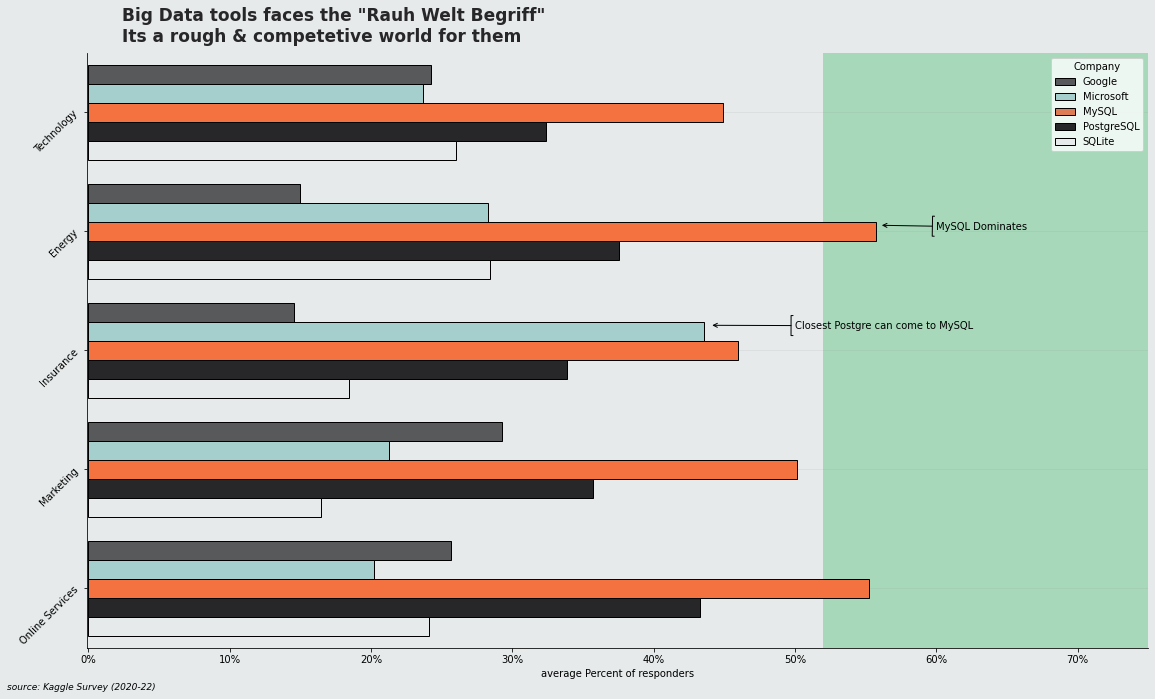

In [111]:
fig, ax = plt.subplots(figsize=(16,9), dpi=72, tight_layout=True)
fig.set_facecolor(BG)
ax.set_facecolor(BG)

sns.barplot(data=spent, x='Percent_of_respondents', y='Category', hue='Company', errorbar=None, ax=ax, palette=[HEAL[1],'#9DD6D2',HEAL[4],HEAL[2],HEAL[0]], edgecolor='black', lw=1)

labels = ['Technology','Energy','Insurance','Marketing', 'Online Services']
ax.set_yticklabels(labels)

for x,patch in enumerate(ax.patches):
    if x in [15,16,17,18,19]:
        patch.set_color(HEAL[2])
    if x in [10,11,12,13,14]:
        patch.set_color(HEAL[4])
    patch.set_edgecolor('black')
    patch.set_linewidth(1)

ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
ax.set_ylabel('')
ax.set_xlabel('average Percent of responders')

# Green Patch
ax.add_patch(
        Rectangle(
            (52,-1), 23, 6, facecolor=color_vals[1], zorder=0,
        ) )

plt.yticks(rotation = 45)
plt.figtext(0, 0.0, 'source: Kaggle Survey (2020-22)', wrap=True, horizontalalignment='left', fontsize=9, style='oblique')
plt.figtext(0.1, 1,'Big Data tools faces the "Rauh Welt Begriff"\nIts a rough & competetive world for them', fontsize=17, fontname='sans-serif', weight='bold', color=HEAL[2])

for x in ax.get_yticks():
    ax.axhline(x, lw=1, color='grey', alpha=0.1, zorder=0)

ax.annotate('MySQL Dominates', xy=(56, .95), xytext=(60, .99), arrowprops=dict(arrowstyle=']->'), zorder=3)
ax.annotate('Closest Postgre can come to MySQL', xy=(44, 1.79), xytext=(50, 1.82), arrowprops=dict(arrowstyle=']->'), zorder=3)

ax.xaxis.set_major_formatter(mtick.PercentFormatter())
ax.set_xlim(-0.1,75)
plt.show()

<b>SQL is old, Boom. I said it,</b> Its atleast 50 years old when a Computer Scientist at IBM suggested a new system for organizig their Data, <b>Why do you need it 50yrs later?</b> One might as well focus on the 'sexier' part of Data Science? Heres 3 quick reasons why you should focus on query languages<br><b>A. SQL is Everywhere</b><br>Virtually all big tech companies use SQL. Uber, Netflix, Airbnb — the list goes on. Even Fortune 500 companies that have built their own high-performance database systems (Facebook, Google, Amazon) still frequently use SQL to query data and perform analyses.<br><b>B. SQL Is in Demand</b><br>If you want to get a job in data, you should focus on the skills employers actually want. As we learnt from our keywords model, more than 50% of listing mention SQL as their key skill<br><b>C. SQL is still the Top Language at Data Work</b><br>SQL is one of the most-used languages in the entire tech industry!. According to Stack Overflow’s 2022 developer survey, SQL eclipses even Python in terms of popularity. In fact, it’s the third-most-popular programming language among all professional developers

In [112]:
role_share = fetch_ts_by_category(frames=[df_21, df_22], year=['2021', '2022'], cat_query=27, ele_query=43)
role_share = role_share.groupby([role_share.Category]).agg({'Percent_of_respondents':'mean'}).reset_index().sort_values(by='Percent_of_respondents', ascending=False)

role_share = role_share[role_share.Category.str.contains(pat='Data')]

role_share.rename({'Category':'Element'}, axis=1, inplace=True)

role_share['Role'] = role_share.apply(lambda row: give_me_role(row), axis=1)

role_share = role_share.groupby([role_share.Role])['Percent_of_respondents'].sum().reset_index()
role_share['share'] = ( role_share.Percent_of_respondents / role_share.Percent_of_respondents.sum() ) * 100

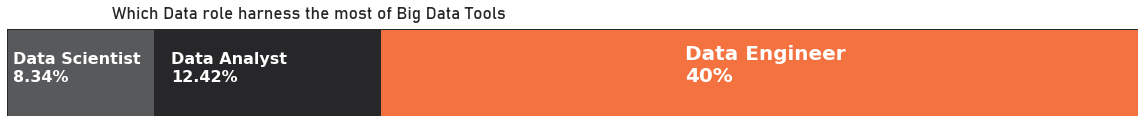

In [113]:
fig, ax = plt.subplots(figsize=(16,1.5), dpi=72, tight_layout=True)
ax.set_xlim(0,1)

ax.add_patch(
   Rectangle(
    (0,0),1,1, facecolor=HEAL[4], edgecolor=HEAL[2], lw=1,
   )
)
ax.add_patch(
   Rectangle(
    (0,0),0.20 + 0.13 ,1, facecolor=HEAL[2], edgecolor=HEAL[2], lw=1,
   )
)
ax.add_patch(
   Rectangle(
    (0,0),0.13,1, facecolor=HEAL[1], edgecolor=HEAL[2], lw=1,
   )
)
ax.text(.6, 0.4, 'Data Engineer\n40%', color='white', fontsize=20, weight='heavy')
ax.text(.145, 0.4, 'Data Analyst\n12.42%', color='white', fontsize=16, weight='heavy')
ax.text(.005, 0.4, 'Data Scientist\n8.34%', color='white', fontsize=16, weight='heavy')

plt.figtext(0.1, 1,'Which Data role harness the most of Big Data Tools', fontsize=17, fontname='Bahnschrift', weight='bold', color=HEAL[2])

ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
ax.spines.bottom.set_visible(False)
ax.spines.left.set_visible(False)
ax.get_yaxis().set_visible(False)
ax.get_xaxis().set_visible(False)

### <div style="font-family: Trebuchet MS; background-color: #272628; color: #FFFFFF; padding: 20px; line-height: 1.5;">Big Data Analytics roles to witness huge demand</div>  
<div style="font-family: Trebuchet MS; background-color: #FFFFFF; color: #000000; padding: 12px; line-height: 1.5;"><b>96% of companies are definitely planning or likely to plan to hire new staff with relevant skills to fill future big data analytics related roles</b> in 2022. This is most likely going to be the most in-demand role in 2022. Data Science, Cloud Computing and Machine Learning roles captured most of the e-recruitment market.<br><b>-Monster</b></div>  

___

#### <div style="font-family: Trebuchet MS; background-color: #6FA4B5; color: #FFFFFF; padding: 12px; line-height: 1.5;">How cloud played a role for this analysys</div>  

<center>
<img src="https://imgur.com/TJOgTUe.jpg" width="900"/></center>


<div style="font-family: Trebuchet MS; background-color: #FFFFFF; color: #000000; padding: 12px; line-height: 1.5;">After collecting Data from <b>Googles Job aggregation page using serpAPI</b>, The tool scrapped different job descriptions and extracted keywords, Few of the features to mention were<br>A. Job Title aka Role<br>B. Type of Job (Full time, Contract, etc)<br>C. Work Location (US)<br>D. Preffered Skills<br>E. Salary<br>
The Data was stored into <b>Google's Cloud storage platform and fed forward to Big Query</b>, Where the tables were stored since having to run the script and uploading everyday wasnt very much like a Good Data Professional, This <b>process was automated and ran everyday automatically</b>. Further, The Keywords were extracted and stored into a Public Table (Please refer references) for everyone to use.<br>Harnessing the power of a Cloud compute Platform is not that difficult, <b>A quick started guide on Big Query could be found in Kaggles own Learning Platform (kaggle.com/learn) </b></div>  

___

<center>
<img src="https://imgur.com/N1V9dYL.jpg" width="900"/></center>

___

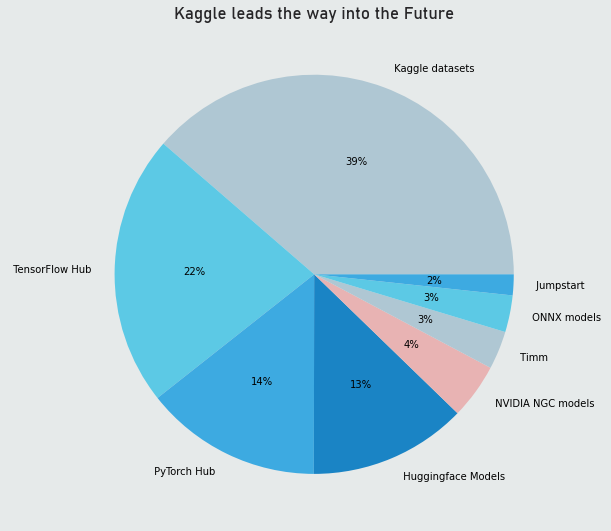

In [114]:
weights_without_role = fetch_ts([df_22], 25, ['2022'], merge=False, append_year=False)
weights_without_role = weights_without_role[~(weights_without_role.Element.isin(['Other storage services (i.e. google drive)','No, I do not download pre-trained model weights on a regular basis']))]

fig, ax = plt.subplots(figsize=(16,9), dpi=72)
ax.set_facecolor(BG)
fig.set_facecolor(BG)

plt.title('Kaggle leads the way into the Future', fontsize=17, fontname='Bahnschrift', weight='bold', color=HEAL[2])

_ = plt.pie(weights_without_role['Percent_of_respondents'], labels = weights_without_role['Element'], colors = STA_HEATMAP, autopct='%.0f%%')

### <div style="font-family: Trebuchet MS; background-color: #272628; color: #FFFFFF; padding: 20px; line-height: 1.5;">Kaggle becomes the 'Hub' for Pre-Trained models</div>  
#### <div style="font-family: Trebuchet MS; background-color: #6FA4B5; color: #FFFFFF; padding: 12px; line-height: 1.5;">Building a model from scratch requires a great deal of time and effort. When innovations are happening at a break-neck speed, concentrating all the efforts on building models could prove counterproductive. Apart from time and effort, building models could also set companies back financially, especially startups.<br>Enter pre-trained models. Put simply, it is a model created by a third party to solve a business problem. While it may not be 100 percent accurate, it saves time and effort in building a model from the ground up.<br>-Shraddha Goled, Analytics Mag India</div>  
##### <div style="font-family: Trebuchet MS; background-color: #FFFFFF; color: #000000; padding: 12px; line-height: 1.5;"><b>"Not everyone should code" & "Not everyone should build models" - Pranav.</b><br>Using a pre trained weight has its own advantages,<br>A. I do not need <b>enormous amounts of Data</b> to build a model from Scratch<br>B. They are simply <b>cost effective and saves Time</b><br>C. Only Thing I need is a Internet connection and a <b><u>platform to host my Notebook on</u></b>, Just like this one</div>  

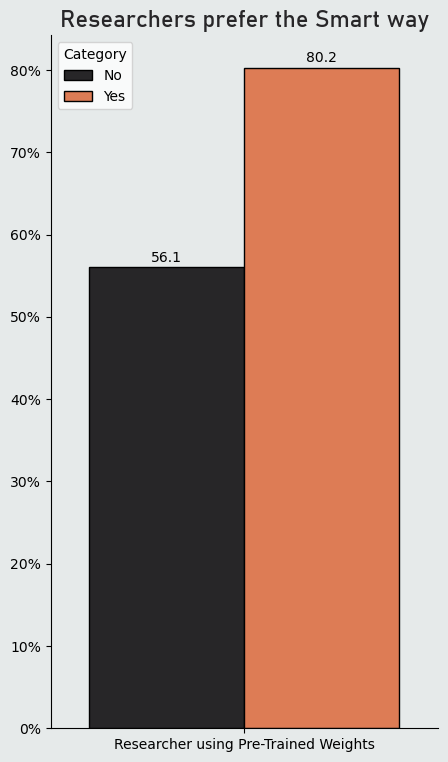

In [115]:
research_weight = fetch_ts_by_category(frames=[df_22], year=['2022'], cat_query=8, ele_query=25)
research_weight = research_weight[~(research_weight['Element'].isin(['Other storage services (i.e. google drive)','No, I do not download pre-trained model weights on a regular basis']))]
research_weight = research_weight.groupby([research_weight.Category])['Percent_of_respondents'].sum().reset_index()
research_weight['X'] = 'Researcher using Pre-Trained Weights'

fig, ax = plt.subplots(figsize=(5,9))
ax.set_facecolor(BG)
fig.set_facecolor(BG)

s = sns.barplot(data=research_weight, x='X', y='Percent_of_respondents', hue='Category', palette=[HEAL[2], HEAL[4]], edgecolor='black', lw=1)
show_values(s, space=0.05)
plt.title('Researchers prefer the Smart way', fontsize=17, fontname='Bahnschrift', weight='bold', color=HEAL[2])

ax.yaxis.set_major_formatter(mtick.PercentFormatter())

ax.spines.top.set_visible(False)
ax.spines.right.set_visible(False)
ax.set_xlabel('')
ax.set_ylabel('')
plt.show()

___

### <div style="font-family: Trebuchet MS; background-color: #272628; color: #FFFFFF; padding: 20px; line-height: 1.5;">A Quick summary</div>  

Lets face it, Data professionals tend to emphasize on <b>Python every now and then, which could potentially undermine other Tools</b>, 8 out of 10 respondents would statisfy the requirement of SQL on a Job Description even tho its being reccommended so less.  
Kagglers are definitely committed to the cloud, Now more than ever, They are opting in to learn Cloud Tools & Products, One would not want to miss this tide and consider learning a Big Data management tool, We could possibly its outcomes in coming surveys.  
As stated by Cloudwards, <b>3 out of 10 workers would prefer to work in the Cloud</b> and would consider looking for a new job if asked to return to office, Cloud is not just a cost and time saving tool, Its a leisure one would not afford loosing.  
Big Data & Analytics would possibily see a huge rise in Demand, all the while the <b>deficit being high as well</b>, This would be a great opportunity for <b>aspirants to munch into and get ahead of the competition. </b>
Supplementing on the Cloud, We realized that not everything should be built from scratch, <b>Building ML Models can be tedious but finding one on Kaggle is not.</b>  
Combined with the power of Low Code - No Code platforms, I would highly encourage the use of Weights to try and find a solution, futhermore contributing to open-source development, <b>Save time, Save money, Save Silion & Ultimately Save the planet.  </b>
Having Cloud proffeciency would not only cut down costs on organizational levels but also help you down at an Individual level, You do not have to worry about how fast your silicon is, how would you store and handle the enormous amounts of information at Hand.


___

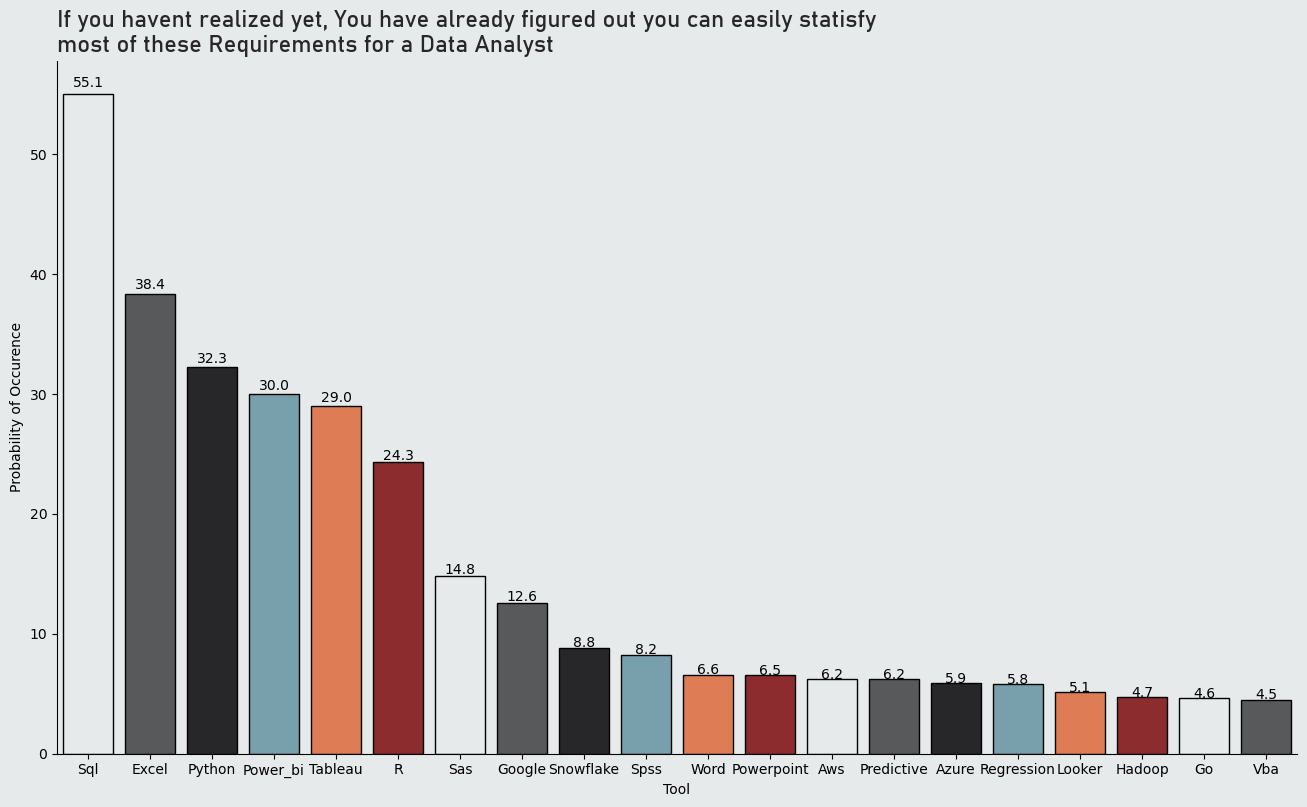

In [116]:
top = pd.read_csv('DataSources/Keywords//kw_top_tools.csv')
fig, ax = plt.subplots(figsize=(16,9))
ax.set_facecolor(BG)
fig.set_facecolor(BG)

bar = sns.barplot(data=top, x='keywords', y='percentage',palette=HEAL, edgecolor='black', lw=1)
show_values(bar, space=0.05)

plt.title('If you havent realized yet, You have already figured out you can easily statisfy\nmost of these Requirements for a Data Analyst', loc='left', fontsize=17, fontname='Bahnschrift', weight='bold', color=HEAL[2])

labels = [str (item.get_text()).capitalize() for item in ax.get_xticklabels()]
ax.set_xticklabels( labels )

ax.spines.top.set_visible(False)
ax.spines.right.set_visible(False)

ax.set_xlabel('Tool')
ax.set_ylabel('Probability of Occurence')
plt.show()

___
### References  
[1] Talks at Google - [Storytelling with Data](https://talksat.withgoogle.com/talk/storytelling-with-data)  
[2] Harvard Business Review - [Why planning is not Strategy](https://online.hbs.edu/blog/post/why-is-strategic-planning-important)  
[3] Matplotlib - [Documentation](https://matplotlib.org/stable/index.html)  
[4] Wired - [Data is the new oil](https://www.wired.com/insights/2014/07/data-new-oil-digital-economy/)  
[5] Harvard Business Review - [How to Protect your job in a Recession](https://hbr.org/2008/09/how-to-protect-your-job-in-a-recession)  
[6] Cloudwars - [Cloud Computing Statistics](https://www.cloudwards.net/cloud-computing-statistics/)  
[7] Analytics Mag India - [Why Companies prefer Pre-Trained Models](https://analyticsindiamag.com/why-do-companies-prefer-pre-trained-models/)  
[8] Forbes - [Data Analytics Profession, Three Trends that Matter](https://www.forbes.com/sites/bernhardschroeder/2021/06/11/the-data-analytics-profession-and-employment-is-exploding-three-trends-that-matter/?sh=1fbef7063f81)  
[9] MIT - [How covid-19 is disrupting data analytics strategies](https://mitsloan.mit.edu/ideas-made-to-matter/how-covid-19-disrupting-data-analytics-strategies)  
[10] Gartner - [10 Trends in Data Analytics after 2020](https://www.gartner.com/smarterwithgartner/gartner-top-10-trends-in-data-and-analytics-for-2020)  
[11] Luke Barousse's Open source project - [Skills for a Data Analyst](https://www.kaggle.com/code/lukebarousse/data-analyst-skill-analysis#More-EDA-of-Top-Skills) | [Video on the process](https://youtu.be/iNEwkaYmPqY) | [subReddit](https://www.reddit.com/r/DataNerd/)  
  
___